In [1]:
# from comet_ml import Experiment
# experiment = Experiment(api_key="xktj4EX0zB8YcQ3BEaFwOQYpu")

In [2]:
import numpy as np
from keras.models import Sequential 
from keras.layers import Dense, Activation
from keras.regularizers import l2
from keras.utils import np_utils 

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import os
import fnmatch

import pandas as pd

import sklearn.preprocessing as preprocessing
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt

import itertools

import scipy.stats as stats

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Load Data

In [4]:
train_path = "I:\\Honours-Project\\data\\sorted\\agg\\train\\"
train_csv = "I:\\Honours-Project\\data\\sorted\\agg\\train\\ids.csv"
test_path = "I:\\Honours-Project\\data\\sorted\\agg\\test\\"
test_csv = "I:\\Honours-Project\\data\\sorted\\agg\\test\\ids.csv"

dest_path = "I:\\Honours-Project\\data\\sorted\\agg\\"

csv = "I:\\Honours-Project\\data\\sorted\\agg\\ids.csv"

In [5]:
df = pd.read_csv(csv,index_col=0).sample(frac=1)

### Downsample to balanced classes

In [6]:
ds_count = min(df.groupby('flow_rate').size())
ds_flow = df.groupby('flow_rate').size().idxmin()

samples = pd.concat([df[df['flow_rate']==i].sample(n=ds_count) for i in (1800,3600,7200)],ignore_index=True)

df = samples.sample(frac=1)

print(samples.groupby('flow_rate').size())

flow_rate
1800    116
3600    116
7200    116
dtype: int64


### Drop columns which we aren't using as features

In [7]:
def drop_cols(df):
    return df.drop(columns=['name','date','flow_rate','source','moments',
                            'inertia_tensor','euler_number','num_peaks','cluster']).as_matrix()

In [8]:
df['log_volume'] = df['volume'].apply(np.log)

x = df.drop(columns=['name','date','flow_rate','source','moments','inertia_tensor'])

# Drop catagorical features
mat = x.drop(columns=['euler_number', 'num_peaks', 'cluster'])

x = mat.as_matrix()
# x = standardize = preprocessing.scale(x)

### Ignore this block

In [9]:
test_size = int(df.shape[0]/10)

x_test = np.array(x[:test_size])
y_test = df['flow_rate'][:test_size].values

x_train = np.array(x[test_size:])
y_train = df['flow_rate'][test_size:].values

std = np.std(x_train,0)
mean = np.mean(x_train,0)
    
x_train = (x_train-mean)/std
x_test = (x_test-mean)/std    

### Split data into balanced test and training sets

In [10]:
x_test = pd.concat([df[df['flow_rate']==i].sample(n=10) for i in (1800,3600,7200)],ignore_index=True)
y_test = x_test['flow_rate'].values

x_train = pd.concat([df, x_test, x_test]).drop_duplicates(keep=False)
y_train = x_train['flow_rate'].values

x_test = drop_cols(x_test)
x_train = drop_cols(x_train)

print(x_train.shape)
print(x_test.shape)

std = np.std(x_train,0)
mean = np.mean(x_train,0)
    
x_train = (x_train-mean)/std
x_test = (x_test-mean)/std    

(318, 9)
(30, 9)


## Run Logistic Regression

In [11]:
batch_size = 16
nb_classes = 3
nb_epoch = 30

lmda = 0.001

In [12]:
input_dim = x_train.shape[1]

In [13]:
y_train[y_train == 1800] = 0
y_train[y_train == 3600] = 1
y_train[y_train == 7200] = 2

y_test[y_test == 1800] = 0
y_test[y_test == 3600] = 1
y_test[y_test == 7200] = 2

y_train = np_utils.to_categorical(y_train, nb_classes) 
y_test = np_utils.to_categorical(y_test, nb_classes)

In [14]:
def build_logistic_model(input_dim, output_dim, lmda):
    model = Sequential()
    model.add(Dense(output_dim, input_dim=input_dim,
                    kernel_regularizer=l2(lmda),
                    activation='softmax'))
    
    return model

def compile_model(input_dim, output_dim, lmda, optimizer):
    model = build_logistic_model(input_dim,output_dim,lmda)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [15]:
model = None
model = build_logistic_model(input_dim, nb_classes,lmda)

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________


## Compile the model

In [17]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=batch_size, epochs=nb_epoch,
                    verbose=1, validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)

Train on 318 samples, validate on 30 samples
Epoch 1/30
318/318 [==============================] - 3s 9ms/step - loss: 1.4233 - acc: 0.3459 - val_loss: 1.3230 - val_acc: 0.4000
Epoch 2/30
318/318 [==============================] - 0s 239us/step - loss: 1.3595 - acc: 0.3522 - val_loss: 1.2859 - val_acc: 0.3667
Epoch 3/30
318/318 [==============================] - 0s 280us/step - loss: 1.3086 - acc: 0.3648 - val_loss: 1.2611 - val_acc: 0.3667
Epoch 4/30
318/318 [==============================] - 0s 258us/step - loss: 1.2684 - acc: 0.3679 - val_loss: 1.2467 - val_acc: 0.4667
Epoch 5/30
318/318 [==============================] - 0s 245us/step - loss: 1.2369 - acc: 0.3648 - val_loss: 1.2385 - val_acc: 0.4000
Epoch 6/30
318/318 [==============================] - 0s 242us/step - loss: 1.2115 - acc: 0.3679 - val_loss: 1.2339 - val_acc: 0.4000
Epoch 7/30
318/318 [==============================] - 0s 236us/step - loss: 1.1913 - acc: 0.3774 - val_loss: 1.2317 - val_acc: 0.3333
Epoch 8/30
318/318 

In [18]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 1.187620759010315
Test accuracy: 0.3333333432674408


## Confusion Matrix

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

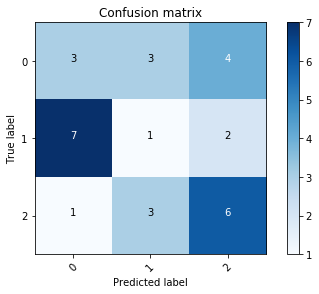

In [20]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3)) 

## LR With Cross Validation

In [36]:
batch_size = 8
nb_classes = 3
lmda = 0.01

nb_epoch = 10

In [31]:
def train_and_evaluate_model(model, x_train, y_train, x_test, y_test):
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                    batch_size=batch_size, epochs=nb_epoch,
                    verbose=1, validation_data=(x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose=2)
    return score[1]

In [37]:
n_folds = 10

labels = df['flow_rate'].values
data = x

labels[labels == 1800] = 0
labels[labels == 3600] = 1
labels[labels == 7200] = 2

one_hot = np_utils.to_categorical(labels, nb_classes) 

skf = StratifiedKFold(df['flow_rate'].values, n_folds=n_folds, shuffle=True)
avg_acc = 0

y_true = []
y_pred = []

for i, (train, test) in enumerate(skf):
    print("Running Fold", i+1, "/", n_folds)
    model = None # Clearing the NN.
    model = build_logistic_model(input_dim, nb_classes, lmda)
    
    std = np.std(data[train],0)
    mean = np.mean(data[train],0)
    
    x_train = (data[train]-mean)/std
    x_test = (data[test] - mean)/std        
    
    avg_acc += train_and_evaluate_model(model, x_train, one_hot[train], x_test, one_hot[test])
    
    # Predict the values from the validation dataset
    Y_pred = model.predict(x_test)
    # Convert predictions classes to one hot vectors 
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    # Convert validation observations to one hot vectors
    Y_true = np.argmax(one_hot[test],axis = 1) 
    
    y_true.extend(Y_true)
    y_pred.extend(Y_pred_classes)

Running Fold 1 / 10
Train on 312 samples, validate on 36 samples
Epoch 1/10
312/312 [==============================] - 15s 47ms/step - loss: 1.3118 - acc: 0.3077 - val_loss: 1.2115 - val_acc: 0.3611
Epoch 2/10
312/312 [==============================] - 0s 1ms/step - loss: 1.2558 - acc: 0.3045 - val_loss: 1.1414 - val_acc: 0.3889
Epoch 3/10
312/312 [==============================] - 0s 1ms/step - loss: 1.2128 - acc: 0.3237 - val_loss: 1.0923 - val_acc: 0.4444
Epoch 4/10
312/312 [==============================] - 0s 1ms/step - loss: 1.1809 - acc: 0.3301 - val_loss: 1.0569 - val_acc: 0.4722
Epoch 5/10
312/312 [==============================] - 0s 1ms/step - loss: 1.1563 - acc: 0.3397 - val_loss: 1.0307 - val_acc: 0.4444
Epoch 6/10
312/312 [==============================] - 0s 1ms/step - loss: 1.1380 - acc: 0.3365 - val_loss: 1.0135 - val_acc: 0.4444
Epoch 7/10
312/312 [==============================] - 0s 1ms/step - loss: 1.1238 - acc: 0.3429 - val_loss: 1.0007 - val_acc: 0.4722
Epoch 8/1

312/312 [==============================] - 0s 910us/step - loss: 1.1028 - acc: 0.3974 - val_loss: 1.1921 - val_acc: 0.3611
Epoch 10/10
312/312 [==============================] - 0s 849us/step - loss: 1.0961 - acc: 0.4006 - val_loss: 1.1853 - val_acc: 0.3611
Running Fold 7 / 10
Train on 315 samples, validate on 33 samples
Epoch 1/10
315/315 [==============================] - 16s 49ms/step - loss: 1.5162 - acc: 0.3587 - val_loss: 1.2078 - val_acc: 0.3939
Epoch 2/10
315/315 [==============================] - 0s 1ms/step - loss: 1.3312 - acc: 0.3683 - val_loss: 1.1510 - val_acc: 0.3636
Epoch 3/10
315/315 [==============================] - 0s 1ms/step - loss: 1.2154 - acc: 0.3651 - val_loss: 1.1250 - val_acc: 0.3939
Epoch 4/10
315/315 [==============================] - 0s 1ms/step - loss: 1.1506 - acc: 0.3968 - val_loss: 1.1156 - val_acc: 0.3636
Epoch 5/10
315/315 [==============================] - 0s 1ms/step - loss: 1.1170 - acc: 0.4000 - val_loss: 1.1157 - val_acc: 0.3939
Epoch 6/10
315/

In [38]:
print("Average Accuracy: ", avg_acc/n_folds)

Average Accuracy:  0.38333333333333336


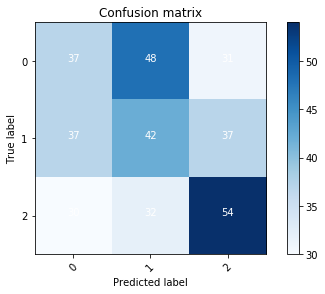

In [39]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(np.array(y_true), np.array(y_pred)) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3)) 

## Grid Search on Hyper-parameters

Note: Test dataset size is wrong?

Also: This takes a while!

In [26]:
model = KerasClassifier(build_fn=compile_model,input_dim=input_dim, output_dim=nb_classes, optimizer='sgd')

param_grid = dict(epochs=[10,20,30], batch_size=[4,8,16,32], lmda=[0.001,0.005,0.01,0.05,0.1])
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, verbose=2)
grid_result = grid.fit(data, one_hot)

Fitting 10 folds for each of 60 candidates, totalling 600 fits
[CV] batch_size=4, epochs=10, lmda=0.001 .............................
Epoch 1/10
313/313 [==============================] - 1s 2ms/step - loss: 10.8322 - acc: 0.3355
Epoch 2/10
313/313 [==============================] - 0s 766us/step - loss: 12.3184 - acc: 0.3259
Epoch 3/10
313/313 [==============================] - 0s 808us/step - loss: 12.3138 - acc: 0.3259
Epoch 4/10
313/313 [==============================] - 0s 817us/step - loss: 12.3092 - acc: 0.3259
Epoch 5/10
313/313 [==============================] - 0s 782us/step - loss: 12.3047 - acc: 0.3259
Epoch 6/10
313/313 [==============================] - 0s 859us/step - loss: 12.3001 - acc: 0.3259
Epoch 7/10
313/313 [==============================] - 0s 786us/step - loss: 12.2956 - acc: 0.3259
Epoch 8/10
313/313 [==============================] - 0s 929us/step - loss: 12.2911 - acc: 0.3259
Epoch 9/10
313/313 [==============================] - 0s 814us/step - loss: 12.2866 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s


313/313 [==============================] - 1s 2ms/step - loss: 11.4846 - acc: 0.3323
Epoch 2/10
313/313 [==============================] - 0s 766us/step - loss: 11.6484 - acc: 0.3259
Epoch 3/10
313/313 [==============================] - 0s 830us/step - loss: 11.6459 - acc: 0.3259
Epoch 4/10
313/313 [==============================] - 0s 785us/step - loss: 11.6434 - acc: 0.3259
Epoch 5/10
313/313 [==============================] - 0s 779us/step - loss: 11.6410 - acc: 0.3259
Epoch 6/10
313/313 [==============================] - 0s 843us/step - loss: 11.6385 - acc: 0.3259
Epoch 7/10
313/313 [==============================] - 0s 795us/step - loss: 11.6361 - acc: 0.3259
Epoch 8/10
313/313 [==============================] - 0s 802us/step - loss: 11.6337 - acc: 0.3259
Epoch 9/10
313/313 [==============================] - 0s 872us/step - loss: 11.6312 - acc: 0.3259
Epoch 10/10
313/313 [==============================] - 0s 415us/step
[CV] .............. batch_size=4, epochs=10, lmda=0.001, total

313/313 [==============================] - 0s 869us/step - loss: 10.6129 - acc: 0.3419
Epoch 10/10
313/313 [==============================] - 0s 422us/step
[CV] .............. batch_size=4, epochs=10, lmda=0.001, total=   3.2s
[CV] batch_size=4, epochs=10, lmda=0.001 .............................
Epoch 1/10
314/314 [==============================] - 1s 2ms/step - loss: 10.5283 - acc: 0.3471
Epoch 2/10
314/314 [==============================] - 0s 796us/step - loss: 10.5283 - acc: 0.3471
Epoch 3/10
314/314 [==============================] - 0s 821us/step - loss: 10.5283 - acc: 0.3471
Epoch 4/10
314/314 [==============================] - 0s 777us/step - loss: 10.5282 - acc: 0.3471
Epoch 5/10
314/314 [==============================] - 0s 815us/step - loss: 10.5282 - acc: 0.3471
Epoch 6/10
314/314 [==============================] - 0s 780us/step - loss: 10.5282 - acc: 0.3471
Epoch 7/10
314/314 [==============================] - 0s 847us/step - loss: 10.5282 - acc: 0.3471
Epoch 8/10
314/314

313/313 [==============================] - 0s 785us/step - loss: 10.7841 - acc: 0.3323
Epoch 5/10
313/313 [==============================] - 0s 801us/step - loss: 10.7838 - acc: 0.3323
Epoch 6/10
313/313 [==============================] - 0s 814us/step - loss: 10.7835 - acc: 0.3323
Epoch 7/10
313/313 [==============================] - 0s 766us/step - loss: 10.7831 - acc: 0.3323
Epoch 8/10
313/313 [==============================] - 0s 833us/step - loss: 10.7828 - acc: 0.3323
Epoch 9/10
313/313 [==============================] - 0s 801us/step - loss: 10.7825 - acc: 0.3323
Epoch 10/10
313/313 [==============================] - 0s 367us/step
[CV] .............. batch_size=4, epochs=10, lmda=0.005, total=   3.3s
[CV] batch_size=4, epochs=10, lmda=0.005 .............................
Epoch 1/10
313/313 [==============================] - 1s 3ms/step - loss: 10.6850 - acc: 0.3387
Epoch 2/10
313/313 [==============================] - 0s 952us/step - loss: 10.6846 - acc: 0.3387
Epoch 3/10
313/313

313/313 [==============================] - 0s 444us/step
[CV] ............... batch_size=4, epochs=10, lmda=0.01, total=   4.0s
[CV] batch_size=4, epochs=10, lmda=0.01 ..............................
Epoch 1/10
313/313 [==============================] - 1s 3ms/step - loss: 10.8032 - acc: 0.3323
Epoch 2/10
313/313 [==============================] - 0s 853us/step - loss: 10.8019 - acc: 0.3323
Epoch 3/10
313/313 [==============================] - 0s 865us/step - loss: 10.8007 - acc: 0.3323
Epoch 4/10
313/313 [==============================] - 0s 862us/step - loss: 10.7995 - acc: 0.3323
Epoch 5/10
313/313 [==============================] - 0s 875us/step - loss: 10.7983 - acc: 0.3323
Epoch 6/10
313/313 [==============================] - 0s 878us/step - loss: 10.7972 - acc: 0.3323
Epoch 7/10
313/313 [==============================] - 0s 846us/step - loss: 10.7962 - acc: 0.3323
Epoch 8/10
313/313 [==============================] - 0s 872us/step - loss: 10.7951 - acc: 0.3323
Epoch 9/10
313/313 

313/313 [==============================] - 0s 904us/step - loss: 10.8515 - acc: 0.3291
Epoch 8/10
313/313 [==============================] - 0s 913us/step - loss: 10.8503 - acc: 0.3291
Epoch 9/10
313/313 [==============================] - 0s 872us/step - loss: 10.8492 - acc: 0.3291
Epoch 10/10
313/313 [==============================] - 0s 450us/step
[CV] ............... batch_size=4, epochs=10, lmda=0.01, total=   4.4s
[CV] batch_size=4, epochs=10, lmda=0.01 ..............................
Epoch 1/10
314/314 [==============================] - 1s 3ms/step - loss: 10.6179 - acc: 0.3439
Epoch 2/10
314/314 [==============================] - 0s 856us/step - loss: 10.6165 - acc: 0.3439
Epoch 3/10
314/314 [==============================] - 0s 863us/step - loss: 10.6152 - acc: 0.3439
Epoch 4/10
314/314 [==============================] - 0s 891us/step - loss: 10.6139 - acc: 0.3439
Epoch 5/10
314/314 [==============================] - 0s 853us/step - loss: 10.6127 - acc: 0.3439
Epoch 6/10
314/314

313/313 [==============================] - 0s 837us/step - loss: 11.0775 - acc: 0.3227
Epoch 3/10
313/313 [==============================] - 0s 827us/step - loss: 11.0540 - acc: 0.3227
Epoch 4/10
313/313 [==============================] - 0s 805us/step - loss: 11.0340 - acc: 0.3227
Epoch 5/10
313/313 [==============================] - 0s 795us/step - loss: 11.0169 - acc: 0.3227
Epoch 6/10
313/313 [==============================] - 0s 817us/step - loss: 11.0023 - acc: 0.3227
Epoch 7/10
313/313 [==============================] - 0s 789us/step - loss: 10.9898 - acc: 0.3227
Epoch 8/10
313/313 [==============================] - 0s 824us/step - loss: 10.9792 - acc: 0.3227
Epoch 9/10
313/313 [==============================] - 0s 827us/step - loss: 10.9701 - acc: 0.3227
Epoch 10/10
313/313 [==============================] - 0s 428us/step
[CV] ............... batch_size=4, epochs=10, lmda=0.05, total=   3.8s
[CV] batch_size=4, epochs=10, lmda=0.05 ..............................
Epoch 1/10
313/3

313/313 [==============================] - 0s 441us/step
[CV] ................ batch_size=4, epochs=10, lmda=0.1, total=   4.6s
[CV] batch_size=4, epochs=10, lmda=0.1 ...............................
Epoch 1/10
313/313 [==============================] - 1s 4ms/step - loss: 11.2170 - acc: 0.3259
Epoch 2/10
313/313 [==============================] - 0s 1ms/step - loss: 11.1217 - acc: 0.3259
Epoch 3/10
313/313 [==============================] - 0s 833us/step - loss: 11.0523 - acc: 0.3259
Epoch 4/10
313/313 [==============================] - 0s 865us/step - loss: 11.0016 - acc: 0.3259
Epoch 5/10
313/313 [==============================] - 0s 833us/step - loss: 10.9647 - acc: 0.3259
Epoch 6/10
313/313 [==============================] - 0s 843us/step - loss: 10.9378 - acc: 0.3259
Epoch 7/10
313/313 [==============================] - 0s 833us/step - loss: 10.9182 - acc: 0.3259
Epoch 8/10
313/313 [==============================] - 0s 1ms/step - loss: 10.9039 - acc: 0.3259
Epoch 9/10
313/313 [===

313/313 [==============================] - 0s 856us/step - loss: 10.8407 - acc: 0.3355
Epoch 6/10
313/313 [==============================] - 0s 900us/step - loss: 29.1263 - acc: 0.3323
Epoch 7/10
313/313 [==============================] - 0s 817us/step - loss: 241.3408 - acc: 0.3419
Epoch 8/10
313/313 [==============================] - 0s 875us/step - loss: 178.7727 - acc: 0.3419
Epoch 9/10
313/313 [==============================] - 0s 856us/step - loss: 133.1713 - acc: 0.3419
Epoch 10/10
313/313 [==============================] - 0s 402us/step
[CV] ................ batch_size=4, epochs=10, lmda=0.1, total=   4.3s
[CV] batch_size=4, epochs=10, lmda=0.1 ...............................
Epoch 1/10
314/314 [==============================] - 1s 4ms/step - loss: 11.3846 - acc: 0.3153
Epoch 2/10
314/314 [==============================] - 0s 904us/step - loss: 11.2901 - acc: 0.3153
Epoch 3/10
314/314 [==============================] - 0s 898us/step - loss: 11.2213 - acc: 0.3153
Epoch 4/10
314/

313/313 [==============================] - 0s 916us/step - loss: 10.8191 - acc: 0.3291
Epoch 6/20
313/313 [==============================] - 0s 843us/step - loss: 10.8191 - acc: 0.3291
Epoch 7/20
313/313 [==============================] - 0s 801us/step - loss: 10.8191 - acc: 0.3291
Epoch 8/20
313/313 [==============================] - 0s 888us/step - loss: 10.8191 - acc: 0.3291
Epoch 9/20
313/313 [==============================] - 0s 872us/step - loss: 10.8191 - acc: 0.3291
Epoch 10/20
313/313 [==============================] - 0s 872us/step - loss: 10.8190 - acc: 0.3291
Epoch 11/20
313/313 [==============================] - 0s 840us/step - loss: 10.8190 - acc: 0.3291
Epoch 12/20
313/313 [==============================] - 0s 907us/step - loss: 10.8190 - acc: 0.3291
Epoch 13/20
313/313 [==============================] - 0s 872us/step - loss: 10.8190 - acc: 0.3291
Epoch 14/20
313/313 [==============================] - 0s 808us/step - loss: 10.8190 - acc: 0.3291
Epoch 15/20
313/313 [=====

313/313 [==============================] - 0s 399us/step
[CV] .............. batch_size=4, epochs=20, lmda=0.001, total=   7.6s
[CV] batch_size=4, epochs=20, lmda=0.001 .............................
Epoch 1/20
313/313 [==============================] - 2s 5ms/step - loss: 10.7140 - acc: 0.3355
Epoch 2/20
313/313 [==============================] - 0s 952us/step - loss: 10.7140 - acc: 0.3355
Epoch 3/20
313/313 [==============================] - 0s 817us/step - loss: 10.7139 - acc: 0.3355
Epoch 4/20
313/313 [==============================] - 0s 904us/step - loss: 10.7139 - acc: 0.3355
Epoch 5/20
313/313 [==============================] - 0s 840us/step - loss: 10.7139 - acc: 0.3355
Epoch 6/20
313/313 [==============================] - 0s 916us/step - loss: 10.7139 - acc: 0.3355
Epoch 7/20
313/313 [==============================] - 0s 859us/step - loss: 10.7139 - acc: 0.3355
Epoch 8/20
313/313 [==============================] - 0s 843us/step - loss: 10.7139 - acc: 0.3355
Epoch 9/20
313/313 

314/314 [==============================] - 0s 808us/step - loss: 12.3639 - acc: 0.3535
Epoch 13/20
314/314 [==============================] - 0s 847us/step - loss: 12.3578 - acc: 0.3535
Epoch 14/20
314/314 [==============================] - 0s 875us/step - loss: 12.3516 - acc: 0.3535
Epoch 15/20
314/314 [==============================] - 0s 843us/step - loss: 12.3455 - acc: 0.3535
Epoch 16/20
314/314 [==============================] - 0s 888us/step - loss: 12.3395 - acc: 0.3535
Epoch 17/20
314/314 [==============================] - 0s 837us/step - loss: 12.3334 - acc: 0.3535
Epoch 18/20
314/314 [==============================] - 0s 882us/step - loss: 12.3274 - acc: 0.3535
Epoch 19/20
314/314 [==============================] - 0s 821us/step - loss: 12.3214 - acc: 0.3535
Epoch 20/20
314/314 [==============================] - 0s 439us/step
[CV] .............. batch_size=4, epochs=20, lmda=0.001, total=   7.4s
[CV] batch_size=4, epochs=20, lmda=0.005 .............................
Epoch 1/2

313/313 [==============================] - 0s 929us/step - loss: 10.8360 - acc: 0.3291
Epoch 5/20
313/313 [==============================] - 0s 849us/step - loss: 10.8357 - acc: 0.3291
Epoch 6/20
313/313 [==============================] - 0s 900us/step - loss: 10.8353 - acc: 0.3291
Epoch 7/20
313/313 [==============================] - 0s 920us/step - loss: 10.8350 - acc: 0.3291
Epoch 8/20
313/313 [==============================] - 0s 878us/step - loss: 10.8347 - acc: 0.3291
Epoch 9/20
313/313 [==============================] - 0s 872us/step - loss: 10.8343 - acc: 0.3291
Epoch 10/20
313/313 [==============================] - 0s 869us/step - loss: 10.8340 - acc: 0.3291
Epoch 11/20
313/313 [==============================] - 0s 865us/step - loss: 10.8337 - acc: 0.3291
Epoch 12/20
313/313 [==============================] - 0s 862us/step - loss: 10.8334 - acc: 0.3291
Epoch 13/20
313/313 [==============================] - 0s 888us/step - loss: 10.8331 - acc: 0.3291
Epoch 14/20
313/313 [======

313/313 [==============================] - 0s 881us/step - loss: 10.9875 - acc: 0.3195
Epoch 20/20
313/313 [==============================] - 0s 421us/step
[CV] .............. batch_size=4, epochs=20, lmda=0.005, total=   7.7s
[CV] batch_size=4, epochs=20, lmda=0.005 .............................
Epoch 1/20
313/313 [==============================] - 2s 6ms/step - loss: 10.6304 - acc: 0.3419
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 10.6300 - acc: 0.3419
Epoch 3/20
313/313 [==============================] - 0s 888us/step - loss: 10.6297 - acc: 0.3419
Epoch 4/20
313/313 [==============================] - 0s 948us/step - loss: 10.6293 - acc: 0.3419
Epoch 5/20
313/313 [==============================] - 0s 853us/step - loss: 10.6290 - acc: 0.3419
Epoch 6/20
313/313 [==============================] - 0s 900us/step - loss: 10.6287 - acc: 0.3419
Epoch 7/20
313/313 [==============================] - 0s 862us/step - loss: 10.6284 - acc: 0.3419
Epoch 8/20
313/313 [

313/313 [==============================] - 0s 823us/step - loss: 14.0721 - acc: 0.3291
Epoch 13/20
313/313 [==============================] - 0s 806us/step - loss: 13.9707 - acc: 0.3291
Epoch 14/20
313/313 [==============================] - 0s 862us/step - loss: 13.8725 - acc: 0.3291
Epoch 15/20
313/313 [==============================] - 0s 846us/step - loss: 13.7774 - acc: 0.3291
Epoch 16/20
313/313 [==============================] - 0s 856us/step - loss: 13.6852 - acc: 0.3291
Epoch 17/20
313/313 [==============================] - 0s 865us/step - loss: 13.5959 - acc: 0.3291
Epoch 18/20
313/313 [==============================] - 0s 894us/step - loss: 13.5093 - acc: 0.3291
Epoch 19/20
313/313 [==============================] - 0s 885us/step - loss: 13.4255 - acc: 0.3291
Epoch 20/20
313/313 [==============================] - 0s 421us/step
[CV] ............... batch_size=4, epochs=20, lmda=0.01, total=   7.7s
[CV] batch_size=4, epochs=20, lmda=0.01 ..............................
Epoch 1/2

313/313 [==============================] - 0s 884us/step - loss: 10.5901 - acc: 0.3450
Epoch 5/20
313/313 [==============================] - 0s 894us/step - loss: 10.5890 - acc: 0.3450
Epoch 6/20
313/313 [==============================] - 0s 904us/step - loss: 10.5880 - acc: 0.3450
Epoch 7/20
313/313 [==============================] - 0s 884us/step - loss: 10.5870 - acc: 0.3450
Epoch 8/20
313/313 [==============================] - 0s 862us/step - loss: 10.5861 - acc: 0.3450
Epoch 9/20
313/313 [==============================] - 0s 920us/step - loss: 10.5852 - acc: 0.3450
Epoch 10/20
313/313 [==============================] - 0s 878us/step - loss: 10.5843 - acc: 0.3450
Epoch 11/20
313/313 [==============================] - 0s 894us/step - loss: 10.5834 - acc: 0.3450
Epoch 12/20
313/313 [==============================] - 0s 833us/step - loss: 10.5826 - acc: 0.3450
Epoch 13/20
313/313 [==============================] - 0s 884us/step - loss: 10.5818 - acc: 0.3450
Epoch 14/20
313/313 [======

313/313 [==============================] - 0s 917us/step - loss: 10.9925 - acc: 0.3195
Epoch 20/20
313/313 [==============================] - 0s 489us/step
[CV] ............... batch_size=4, epochs=20, lmda=0.01, total=   8.2s
[CV] batch_size=4, epochs=20, lmda=0.01 ..............................
Epoch 1/20
314/314 [==============================] - 2s 6ms/step - loss: 11.0519 - acc: 0.3439
Epoch 2/20
314/314 [==============================] - 0s 1ms/step - loss: 11.4555 - acc: 0.3439
Epoch 3/20
314/314 [==============================] - 0s 910us/step - loss: 11.4281 - acc: 0.3439
Epoch 4/20
314/314 [==============================] - 0s 885us/step - loss: 11.4015 - acc: 0.3439
Epoch 5/20
314/314 [==============================] - 0s 875us/step - loss: 11.3758 - acc: 0.3439
Epoch 6/20
314/314 [==============================] - 0s 926us/step - loss: 11.3509 - acc: 0.3439
Epoch 7/20
314/314 [==============================] - 0s 853us/step - loss: 11.3267 - acc: 0.3439
Epoch 8/20
314/314 [

313/313 [==============================] - 0s 936us/step - loss: 10.9509 - acc: 0.3227
Epoch 12/20
313/313 [==============================] - 0s 916us/step - loss: 10.9459 - acc: 0.3227
Epoch 13/20
313/313 [==============================] - 0s 977us/step - loss: 10.9417 - acc: 0.3227
Epoch 14/20
313/313 [==============================] - 0s 926us/step - loss: 10.9381 - acc: 0.3227
Epoch 15/20
313/313 [==============================] - 0s 920us/step - loss: 10.9350 - acc: 0.3227
Epoch 16/20
313/313 [==============================] - 0s 939us/step - loss: 10.9324 - acc: 0.3227
Epoch 17/20
313/313 [==============================] - 0s 1ms/step - loss: 10.9301 - acc: 0.3227
Epoch 18/20
313/313 [==============================] - 0s 1ms/step - loss: 10.9282 - acc: 0.3227
Epoch 19/20
313/313 [==============================] - 0s 1ms/step - loss: 12.8353 - acc: 0.3291
Epoch 20/20
313/313 [==============================] - 0s 511us/step
[CV] ............... batch_size=4, epochs=20, lmda=0.05, t

313/313 [==============================] - 0s 904us/step - loss: 10.8771 - acc: 0.3323
Epoch 5/20
313/313 [==============================] - 0s 939us/step - loss: 10.8604 - acc: 0.3323
Epoch 6/20
313/313 [==============================] - 0s 987us/step - loss: 10.8461 - acc: 0.3323
Epoch 7/20
313/313 [==============================] - 0s 942us/step - loss: 10.8339 - acc: 0.3323
Epoch 8/20
313/313 [==============================] - 0s 904us/step - loss: 10.8234 - acc: 0.3323
Epoch 9/20
313/313 [==============================] - 0s 856us/step - loss: 10.8145 - acc: 0.3323
Epoch 10/20
313/313 [==============================] - 0s 888us/step - loss: 10.8069 - acc: 0.3323
Epoch 11/20
313/313 [==============================] - 0s 894us/step - loss: 10.8004 - acc: 0.3323
Epoch 12/20
313/313 [==============================] - 0s 904us/step - loss: 10.7949 - acc: 0.3323
Epoch 13/20
313/313 [==============================] - 0s 900us/step - loss: 10.7902 - acc: 0.3323
Epoch 14/20
313/313 [======

314/314 [==============================] - 0s 949us/step - loss: 11.0494 - acc: 0.3153
Epoch 20/20
314/314 [==============================] - 0s 439us/step
[CV] ............... batch_size=4, epochs=20, lmda=0.05, total=   8.6s
[CV] batch_size=4, epochs=20, lmda=0.05 ..............................
Epoch 1/20
314/314 [==============================] - 2s 7ms/step - loss: 10.6110 - acc: 0.3535
Epoch 2/20
314/314 [==============================] - 0s 1ms/step - loss: 10.5831 - acc: 0.3535
Epoch 3/20
314/314 [==============================] - 0s 939us/step - loss: 10.5593 - acc: 0.3535
Epoch 4/20
314/314 [==============================] - 0s 926us/step - loss: 10.5390 - acc: 0.3535
Epoch 5/20
314/314 [==============================] - 0s 945us/step - loss: 10.5216 - acc: 0.3535
Epoch 6/20
314/314 [==============================] - 0s 942us/step - loss: 10.5068 - acc: 0.3535
Epoch 7/20
314/314 [==============================] - 0s 971us/step - loss: 10.4941 - acc: 0.3535
Epoch 8/20
314/314 [

313/313 [==============================] - 0s 920us/step - loss: 10.8302 - acc: 0.3291
Epoch 13/20
313/313 [==============================] - 0s 811us/step - loss: 10.8258 - acc: 0.3291
Epoch 14/20
313/313 [==============================] - 0s 884us/step - loss: 10.8226 - acc: 0.3291
Epoch 15/20
313/313 [==============================] - 0s 897us/step - loss: 10.8203 - acc: 0.3291
Epoch 16/20
313/313 [==============================] - 0s 891us/step - loss: 10.8186 - acc: 0.3291
Epoch 17/20
313/313 [==============================] - 0s 894us/step - loss: 10.8174 - acc: 0.3291
Epoch 18/20
313/313 [==============================] - 0s 907us/step - loss: 10.8165 - acc: 0.3291
Epoch 19/20
313/313 [==============================] - 0s 939us/step - loss: 10.8158 - acc: 0.3291
Epoch 20/20
313/313 [==============================] - 0s 504us/step
[CV] ................ batch_size=4, epochs=20, lmda=0.1, total=   8.5s
[CV] batch_size=4, epochs=20, lmda=0.1 ...............................
Epoch 1/2

313/313 [==============================] - 0s 926us/step - loss: 11.0782 - acc: 0.3195
Epoch 6/20
313/313 [==============================] - 0s 1ms/step - loss: 11.0485 - acc: 0.3195
Epoch 7/20
313/313 [==============================] - 0s 884us/step - loss: 11.0268 - acc: 0.3195
Epoch 8/20
313/313 [==============================] - 0s 846us/step - loss: 11.0110 - acc: 0.3195
Epoch 9/20
313/313 [==============================] - 0s 904us/step - loss: 10.9995 - acc: 0.3195
Epoch 10/20
313/313 [==============================] - 0s 942us/step - loss: 10.9911 - acc: 0.3195
Epoch 11/20
313/313 [==============================] - 0s 869us/step - loss: 10.9850 - acc: 0.3195
Epoch 12/20
313/313 [==============================] - 0s 891us/step - loss: 10.9805 - acc: 0.3195
Epoch 13/20
313/313 [==============================] - 0s 884us/step - loss: 10.9773 - acc: 0.3195
Epoch 14/20
313/313 [==============================] - 0s 907us/step - loss: 10.9749 - acc: 0.3195
Epoch 15/20
313/313 [=======

314/314 [==============================] - 0s 455us/step
[CV] ................ batch_size=4, epochs=20, lmda=0.1, total=   8.6s
[CV] batch_size=4, epochs=30, lmda=0.001 .............................
Epoch 1/30
313/313 [==============================] - 2s 8ms/step - loss: 10.5610 - acc: 0.3450
Epoch 2/30
313/313 [==============================] - 0s 958us/step - loss: 10.5610 - acc: 0.3450
Epoch 3/30
313/313 [==============================] - 0s 881us/step - loss: 10.5610 - acc: 0.3450
Epoch 4/30
313/313 [==============================] - 0s 920us/step - loss: 10.5610 - acc: 0.3450
Epoch 5/30
313/313 [==============================] - 0s 897us/step - loss: 10.5610 - acc: 0.3450
Epoch 6/30
313/313 [==============================] - 0s 913us/step - loss: 10.5610 - acc: 0.3450
Epoch 7/30
313/313 [==============================] - 0s 964us/step - loss: 10.5610 - acc: 0.3450
Epoch 8/30
313/313 [==============================] - 0s 948us/step - loss: 10.5609 - acc: 0.3450
Epoch 9/30
313/313 

313/313 [==============================] - 0s 971us/step - loss: 10.4579 - acc: 0.3514
Epoch 16/30
313/313 [==============================] - 0s 936us/step - loss: 10.4579 - acc: 0.3514
Epoch 17/30
313/313 [==============================] - 0s 1ms/step - loss: 10.4579 - acc: 0.3514
Epoch 18/30
313/313 [==============================] - 0s 958us/step - loss: 10.4579 - acc: 0.3514
Epoch 19/30
313/313 [==============================] - 0s 913us/step - loss: 10.4578 - acc: 0.3514
Epoch 20/30
313/313 [==============================] - 0s 1ms/step - loss: 10.4578 - acc: 0.3514
Epoch 21/30
313/313 [==============================] - 0s 1ms/step - loss: 10.4578 - acc: 0.3514
Epoch 22/30
313/313 [==============================] - 0s 916us/step - loss: 10.4578 - acc: 0.3514
Epoch 23/30
313/313 [==============================] - 0s 999us/step - loss: 10.4578 - acc: 0.3514
Epoch 24/30
313/313 [==============================] - 0s 955us/step - loss: 10.4578 - acc: 0.3514
Epoch 25/30
313/313 [=======

Epoch 1/30
313/313 [==============================] - 2s 8ms/step - loss: 10.7679 - acc: 0.3323
Epoch 2/30
313/313 [==============================] - 0s 990us/step - loss: 10.7679 - acc: 0.3323
Epoch 3/30
313/313 [==============================] - 0s 983us/step - loss: 10.7678 - acc: 0.3323
Epoch 4/30
313/313 [==============================] - 0s 1ms/step - loss: 10.7678 - acc: 0.3323
Epoch 5/30
313/313 [==============================] - 0s 993us/step - loss: 10.7678 - acc: 0.3323
Epoch 6/30
313/313 [==============================] - 0s 958us/step - loss: 10.7678 - acc: 0.3323
Epoch 7/30
313/313 [==============================] - 0s 910us/step - loss: 10.7678 - acc: 0.3323
Epoch 8/30
313/313 [==============================] - 0s 961us/step - loss: 10.7678 - acc: 0.3323
Epoch 9/30
313/313 [==============================] - 0s 1ms/step - loss: 10.7677 - acc: 0.3323
Epoch 10/30
313/313 [==============================] - 0s 1ms/step - loss: 10.7677 - acc: 0.3323
Epoch 11/30
313/313 [======

313/313 [==============================] - 0s 1ms/step - loss: 10.7154 - acc: 0.3355
Epoch 20/30
313/313 [==============================] - 0s 1ms/step - loss: 10.7154 - acc: 0.3355
Epoch 21/30
313/313 [==============================] - 0s 1ms/step - loss: 10.7154 - acc: 0.3355
Epoch 22/30
313/313 [==============================] - 0s 1ms/step - loss: 10.7154 - acc: 0.3355
Epoch 23/30
313/313 [==============================] - 0s 2ms/step - loss: 10.7154 - acc: 0.3355
Epoch 24/30
313/313 [==============================] - ETA: 0s - loss: 10.6378 - acc: 0.34 - 0s 2ms/step - loss: 10.7154 - acc: 0.3355
Epoch 25/30
313/313 [==============================] - 0s 1ms/step - loss: 10.7153 - acc: 0.3355
Epoch 26/30
313/313 [==============================] - 0s 2ms/step - loss: 10.7153 - acc: 0.3355
Epoch 27/30
313/313 [==============================] - 0s 2ms/step - loss: 10.7153 - acc: 0.3355
Epoch 28/30
313/313 [==============================] - 0s 1ms/step - loss: 10.7153 - acc: 0.3355
Epoc

313/313 [==============================] - 0s 939us/step - loss: 10.8873 - acc: 0.3259
Epoch 5/30
313/313 [==============================] - 0s 923us/step - loss: 10.8869 - acc: 0.3259
Epoch 6/30
313/313 [==============================] - 0s 961us/step - loss: 10.8866 - acc: 0.3259
Epoch 7/30
313/313 [==============================] - 0s 990us/step - loss: 10.8863 - acc: 0.3259
Epoch 8/30
313/313 [==============================] - 0s 913us/step - loss: 10.8860 - acc: 0.3259
Epoch 9/30
313/313 [==============================] - 0s 1ms/step - loss: 10.8856 - acc: 0.3259
Epoch 10/30
313/313 [==============================] - 0s 980us/step - loss: 10.8853 - acc: 0.3259
Epoch 11/30
313/313 [==============================] - 0s 961us/step - loss: 10.8850 - acc: 0.3259
Epoch 12/30
313/313 [==============================] - 0s 1ms/step - loss: 10.8847 - acc: 0.3259
Epoch 13/30
313/313 [==============================] - 0s 1ms/step - loss: 10.8844 - acc: 0.3259
Epoch 14/30
313/313 [============

313/313 [==============================] - 0s 964us/step - loss: 10.8815 - acc: 0.3259
Epoch 23/30
313/313 [==============================] - 0s 926us/step - loss: 10.8812 - acc: 0.3259
Epoch 24/30
313/313 [==============================] - 0s 983us/step - loss: 10.8810 - acc: 0.3259
Epoch 25/30
313/313 [==============================] - 0s 1ms/step - loss: 10.8807 - acc: 0.3259
Epoch 26/30
313/313 [==============================] - 0s 967us/step - loss: 10.8805 - acc: 0.3259
Epoch 27/30
313/313 [==============================] - 0s 1ms/step - loss: 10.8802 - acc: 0.3259
Epoch 28/30
313/313 [==============================] - 0s 997us/step - loss: 10.8800 - acc: 0.3259
Epoch 29/30
313/313 [==============================] - 0s 1ms/step - loss: 10.8798 - acc: 0.3259
Epoch 30/30
313/313 [==============================] - 0s 492us/step
[CV] .............. batch_size=4, epochs=30, lmda=0.005, total=  12.7s
[CV] batch_size=4, epochs=30, lmda=0.005 .............................
Epoch 1/30
313/

313/313 [==============================] - 0s 932us/step - loss: 10.8821 - acc: 0.3259
Epoch 8/30
313/313 [==============================] - 0s 936us/step - loss: 10.8818 - acc: 0.3259
Epoch 9/30
313/313 [==============================] - 0s 1ms/step - loss: 10.8816 - acc: 0.3259
Epoch 10/30
313/313 [==============================] - 0s 932us/step - loss: 10.8813 - acc: 0.3259
Epoch 11/30
313/313 [==============================] - 0s 939us/step - loss: 10.8811 - acc: 0.3259
Epoch 12/30
313/313 [==============================] - 0s 1ms/step - loss: 10.8808 - acc: 0.3259
Epoch 13/30
313/313 [==============================] - 0s 955us/step - loss: 10.8806 - acc: 0.3259
Epoch 14/30
313/313 [==============================] - 0s 951us/step - loss: 10.8803 - acc: 0.3259
Epoch 15/30
313/313 [==============================] - 0s 971us/step - loss: 10.8801 - acc: 0.3259
Epoch 16/30
313/313 [==============================] - 0s 958us/step - loss: 10.8799 - acc: 0.3259
Epoch 17/30
313/313 [=======

313/313 [==============================] - 0s 884us/step - loss: 25.6498 - acc: 0.3419
Epoch 26/30
313/313 [==============================] - 0s 865us/step - loss: 25.4140 - acc: 0.3419
Epoch 27/30
313/313 [==============================] - 0s 910us/step - loss: 25.1819 - acc: 0.3419
Epoch 28/30
313/313 [==============================] - 0s 888us/step - loss: 24.9534 - acc: 0.3419
Epoch 29/30
313/313 [==============================] - 0s 945us/step - loss: 24.7285 - acc: 0.3419
Epoch 30/30
313/313 [==============================] - 0s 450us/step
[CV] .............. batch_size=4, epochs=30, lmda=0.005, total=  12.0s
[CV] batch_size=4, epochs=30, lmda=0.005 .............................
Epoch 1/30
314/314 [==============================] - 3s 9ms/step - loss: 10.5925 - acc: 0.3439
Epoch 2/30
314/314 [==============================] - 0s 1ms/step - loss: 10.5922 - acc: 0.3439
Epoch 3/30
314/314 [==============================] - 0s 1ms/step - loss: 10.5919 - acc: 0.3439
Epoch 4/30
314/314

313/313 [==============================] - 0s 900us/step - loss: 10.5918 - acc: 0.3450
Epoch 11/30
313/313 [==============================] - 0s 894us/step - loss: 10.5907 - acc: 0.3450
Epoch 12/30
313/313 [==============================] - 0s 888us/step - loss: 10.5897 - acc: 0.3450
Epoch 13/30
313/313 [==============================] - 0s 869us/step - loss: 10.5887 - acc: 0.3450
Epoch 14/30
313/313 [==============================] - 0s 862us/step - loss: 10.5877 - acc: 0.3450
Epoch 15/30
313/313 [==============================] - 0s 907us/step - loss: 10.5867 - acc: 0.3450
Epoch 16/30
313/313 [==============================] - 0s 910us/step - loss: 10.5858 - acc: 0.3450
Epoch 17/30
313/313 [==============================] - 0s 926us/step - loss: 10.5848 - acc: 0.3450
Epoch 18/30
313/313 [==============================] - 0s 971us/step - loss: 10.5840 - acc: 0.3450
Epoch 19/30
313/313 [==============================] - 0s 916us/step - loss: 10.5831 - acc: 0.3450
Epoch 20/30
313/313 [=

313/313 [==============================] - 0s 869us/step - loss: 11.0355 - acc: 0.3163
Epoch 29/30
313/313 [==============================] - 0s 862us/step - loss: 11.0350 - acc: 0.3163
Epoch 30/30
313/313 [==============================] - 0s 482us/step
[CV] ............... batch_size=4, epochs=30, lmda=0.01, total=  12.4s
[CV] batch_size=4, epochs=30, lmda=0.01 ..............................
Epoch 1/30
313/313 [==============================] - 3s 9ms/step - loss: 13.2936 - acc: 0.3259
Epoch 2/30
313/313 [==============================] - 0s 1ms/step - loss: 13.8077 - acc: 0.3291
Epoch 3/30
313/313 [==============================] - 0s 952us/step - loss: 13.7145 - acc: 0.3291
Epoch 4/30
313/313 [==============================] - 0s 971us/step - loss: 13.6243 - acc: 0.3291
Epoch 5/30
313/313 [==============================] - 0s 967us/step - loss: 13.5369 - acc: 0.3291
Epoch 6/30
313/313 [==============================] - 0s 974us/step - loss: 13.4522 - acc: 0.3291
Epoch 7/30
313/313 

313/313 [==============================] - 0s 920us/step - loss: 10.8076 - acc: 0.3323
Epoch 14/30
313/313 [==============================] - 0s 920us/step - loss: 10.8062 - acc: 0.3323
Epoch 15/30
313/313 [==============================] - 0s 888us/step - loss: 10.8049 - acc: 0.3323
Epoch 16/30
313/313 [==============================] - 0s 894us/step - loss: 10.8036 - acc: 0.3323
Epoch 17/30
313/313 [==============================] - 0s 878us/step - loss: 10.8023 - acc: 0.3323
Epoch 18/30
313/313 [==============================] - 0s 945us/step - loss: 10.8011 - acc: 0.3323
Epoch 19/30
313/313 [==============================] - 0s 961us/step - loss: 10.7999 - acc: 0.3323
Epoch 20/30
313/313 [==============================] - 0s 916us/step - loss: 10.7987 - acc: 0.3323
Epoch 21/30
313/313 [==============================] - 0s 932us/step - loss: 10.7976 - acc: 0.3323
Epoch 22/30
313/313 [==============================] - 0s 948us/step - loss: 10.7965 - acc: 0.3323
Epoch 23/30
313/313 [=

313/313 [==============================] - 0s 485us/step
[CV] ............... batch_size=4, epochs=30, lmda=0.01, total=  12.7s
[CV] batch_size=4, epochs=30, lmda=0.01 ..............................
Epoch 1/30
314/314 [==============================] - 3s 9ms/step - loss: 15.3652 - acc: 0.3439
Epoch 2/30
314/314 [==============================] - 0s 1ms/step - loss: 19.2697 - acc: 0.3408
Epoch 3/30
314/314 [==============================] - 0s 984us/step - loss: 19.0008 - acc: 0.3408
Epoch 4/30
314/314 [==============================] - 0s 923us/step - loss: 18.7402 - acc: 0.3408
Epoch 5/30
314/314 [==============================] - 0s 1ms/step - loss: 18.4878 - acc: 0.3408
Epoch 6/30
314/314 [==============================] - 0s 964us/step - loss: 18.2432 - acc: 0.3408
Epoch 7/30
314/314 [==============================] - 0s 945us/step - loss: 18.0062 - acc: 0.3408
Epoch 8/30
314/314 [==============================] - 0s 907us/step - loss: 17.7766 - acc: 0.3408
Epoch 9/30
314/314 [===

313/313 [==============================] - 0s 1ms/step - loss: 119.2252 - acc: 0.3259
Epoch 17/30
313/313 [==============================] - 0s 961us/step - loss: 103.3811 - acc: 0.3259
Epoch 18/30
313/313 [==============================] - 0s 942us/step - loss: 89.8537 - acc: 0.3259
Epoch 19/30
313/313 [==============================] - 0s 964us/step - loss: 78.3042 - acc: 0.3259
Epoch 20/30
313/313 [==============================] - 0s 881us/step - loss: 68.4435 - acc: 0.3259
Epoch 21/30
313/313 [==============================] - 0s 980us/step - loss: 60.0246 - acc: 0.3259
Epoch 22/30
313/313 [==============================] - 0s 920us/step - loss: 52.8366 - acc: 0.3259
Epoch 23/30
313/313 [==============================] - 0s 929us/step - loss: 46.6997 - acc: 0.3259
Epoch 24/30
313/313 [==============================] - 0s 1ms/step - loss: 41.4601 - acc: 0.3259
Epoch 25/30
313/313 [==============================] - 0s 945us/step - loss: 36.9866 - acc: 0.3259
Epoch 26/30
313/313 [===

313/313 [==============================] - 3s 9ms/step - loss: 10.8244 - acc: 0.3419
Epoch 2/30
313/313 [==============================] - 0s 910us/step - loss: 10.7928 - acc: 0.3419
Epoch 3/30
313/313 [==============================] - 0s 999us/step - loss: 10.7658 - acc: 0.3419
Epoch 4/30
313/313 [==============================] - 0s 932us/step - loss: 10.7427 - acc: 0.3419
Epoch 5/30
313/313 [==============================] - 0s 974us/step - loss: 10.7230 - acc: 0.3419
Epoch 6/30
313/313 [==============================] - 0s 1ms/step - loss: 10.7062 - acc: 0.3419
Epoch 7/30
313/313 [==============================] - 0s 990us/step - loss: 10.6919 - acc: 0.3419
Epoch 8/30
313/313 [==============================] - 0s 958us/step - loss: 10.6796 - acc: 0.3419
Epoch 9/30
313/313 [==============================] - 1s 2ms/step - loss: 10.6692 - acc: 0.3419
Epoch 10/30
313/313 [==============================] - 0s 1ms/step - loss: 10.6602 - acc: 0.3419
Epoch 11/30
313/313 [=================

313/313 [==============================] - 0s 900us/step - loss: 10.7740 - acc: 0.3323
Epoch 19/30
313/313 [==============================] - 0s 840us/step - loss: 10.7723 - acc: 0.3323
Epoch 20/30
313/313 [==============================] - 0s 926us/step - loss: 10.7709 - acc: 0.3323
Epoch 21/30
313/313 [==============================] - 0s 929us/step - loss: 10.7697 - acc: 0.3323
Epoch 22/30
313/313 [==============================] - 0s 830us/step - loss: 10.7687 - acc: 0.3323
Epoch 23/30
313/313 [==============================] - 0s 884us/step - loss: 10.7678 - acc: 0.3323
Epoch 24/30
313/313 [==============================] - 0s 891us/step - loss: 10.7670 - acc: 0.3323
Epoch 25/30
313/313 [==============================] - 0s 884us/step - loss: 10.7664 - acc: 0.3323
Epoch 26/30
313/313 [==============================] - 0s 840us/step - loss: 10.7658 - acc: 0.3323
Epoch 27/30
313/313 [==============================] - 0s 865us/step - loss: 10.7653 - acc: 0.3323
Epoch 28/30
313/313 [=

314/314 [==============================] - 0s 904us/step - loss: 10.7587 - acc: 0.3408
Epoch 4/30
314/314 [==============================] - 0s 888us/step - loss: 10.7392 - acc: 0.3408
Epoch 5/30
314/314 [==============================] - 0s 878us/step - loss: 10.7226 - acc: 0.3408
Epoch 6/30
314/314 [==============================] - 0s 929us/step - loss: 10.7084 - acc: 0.3408
Epoch 7/30
314/314 [==============================] - 0s 955us/step - loss: 10.6963 - acc: 0.3408
Epoch 8/30
314/314 [==============================] - 0s 939us/step - loss: 10.6860 - acc: 0.3408
Epoch 9/30
314/314 [==============================] - 0s 977us/step - loss: 10.6772 - acc: 0.3408
Epoch 10/30
314/314 [==============================] - 0s 920us/step - loss: 10.6696 - acc: 0.3408
Epoch 11/30
314/314 [==============================] - 0s 859us/step - loss: 10.6632 - acc: 0.3408
Epoch 12/30
314/314 [==============================] - 0s 856us/step - loss: 10.6577 - acc: 0.3408
Epoch 13/30
314/314 [=======

313/313 [==============================] - 0s 936us/step - loss: 11.3054 - acc: 0.3450
Epoch 22/30
313/313 [==============================] - 0s 977us/step - loss: 11.1023 - acc: 0.3450
Epoch 23/30
313/313 [==============================] - 0s 961us/step - loss: 10.9543 - acc: 0.3450
Epoch 24/30
313/313 [==============================] - 0s 980us/step - loss: 10.8465 - acc: 0.3450
Epoch 25/30
313/313 [==============================] - 0s 1ms/step - loss: 10.7679 - acc: 0.3450
Epoch 26/30
313/313 [==============================] - 0s 1ms/step - loss: 10.7106 - acc: 0.3450
Epoch 27/30
313/313 [==============================] - 0s 907us/step - loss: 10.6688 - acc: 0.3450
Epoch 28/30
313/313 [==============================] - 0s 1ms/step - loss: 10.6384 - acc: 0.3450
Epoch 29/30
313/313 [==============================] - 0s 936us/step - loss: 10.6162 - acc: 0.3450
Epoch 30/30
313/313 [==============================] - 0s 508us/step
[CV] ................ batch_size=4, epochs=30, lmda=0.1, t

313/313 [==============================] - 0s 884us/step - loss: 10.8810 - acc: 0.3291
Epoch 8/30
313/313 [==============================] - 0s 904us/step - loss: 10.8628 - acc: 0.3291
Epoch 9/30
313/313 [==============================] - 0s 907us/step - loss: 10.8496 - acc: 0.3291
Epoch 10/30
313/313 [==============================] - 0s 884us/step - loss: 10.8400 - acc: 0.3291
Epoch 11/30
313/313 [==============================] - 0s 999us/step - loss: 10.8329 - acc: 0.3291
Epoch 12/30
313/313 [==============================] - 0s 959us/step - loss: 10.8278 - acc: 0.3291
Epoch 13/30
313/313 [==============================] - 0s 883us/step - loss: 10.8241 - acc: 0.3291
Epoch 14/30
313/313 [==============================] - 0s 862us/step - loss: 10.8214 - acc: 0.3291
Epoch 15/30
313/313 [==============================] - 0s 967us/step - loss: 10.8194 - acc: 0.3291
Epoch 16/30
313/313 [==============================] - 0s 872us/step - loss: 10.8179 - acc: 0.3291
Epoch 17/30
313/313 [===

313/313 [==============================] - 0s 923us/step - loss: 10.9031 - acc: 0.3355
Epoch 26/30
313/313 [==============================] - 0s 929us/step - loss: 10.8510 - acc: 0.3355
Epoch 27/30
313/313 [==============================] - 0s 955us/step - loss: 10.8131 - acc: 0.3355
Epoch 28/30
313/313 [==============================] - 0s 846us/step - loss: 10.7854 - acc: 0.3355
Epoch 29/30
313/313 [==============================] - 0s 888us/step - loss: 10.7652 - acc: 0.3355
Epoch 30/30
313/313 [==============================] - 0s 450us/step
[CV] ................ batch_size=4, epochs=30, lmda=0.1, total=  13.6s
[CV] batch_size=4, epochs=30, lmda=0.1 ...............................
Epoch 1/30
313/313 [==============================] - 3s 10ms/step - loss: 11.1253 - acc: 0.3419
Epoch 2/30
313/313 [==============================] - 0s 1ms/step - loss: 10.9850 - acc: 0.3419
Epoch 3/30
313/313 [==============================] - 0s 936us/step - loss: 10.8828 - acc: 0.3419
Epoch 4/30
313/

314/314 [==============================] - 1s 2ms/step - loss: 11.0613 - acc: 0.3153
Epoch 11/30
314/314 [==============================] - 0s 1ms/step - loss: 11.0545 - acc: 0.3153
Epoch 12/30
314/314 [==============================] - 0s 1ms/step - loss: 11.0496 - acc: 0.3153
Epoch 13/30
314/314 [==============================] - 1s 2ms/step - loss: 11.0460 - acc: 0.3153
Epoch 14/30
314/314 [==============================] - 0s 2ms/step - loss: 11.0433 - acc: 0.3153
Epoch 15/30
314/314 [==============================] - 0s 1ms/step - loss: 11.0414 - acc: 0.3153
Epoch 16/30
314/314 [==============================] - 0s 1ms/step - loss: 11.0400 - acc: 0.3153
Epoch 17/30
314/314 [==============================] - 0s 2ms/step - loss: 11.0390 - acc: 0.3153
Epoch 18/30
314/314 [==============================] - 0s 1ms/step - loss: 11.0383 - acc: 0.3153
Epoch 19/30
314/314 [==============================] - 1s 2ms/step - loss: 11.0377 - acc: 0.3153
Epoch 20/30
314/314 [=====================

313/313 [==============================] - 0s 453us/step - loss: 10.7664 - acc: 0.3323
Epoch 4/10
313/313 [==============================] - 0s 466us/step - loss: 10.7664 - acc: 0.3323
Epoch 5/10
313/313 [==============================] - 0s 482us/step - loss: 10.7664 - acc: 0.3323
Epoch 6/10
313/313 [==============================] - 0s 473us/step - loss: 10.7664 - acc: 0.3323
Epoch 7/10
313/313 [==============================] - 0s 533us/step - loss: 10.7664 - acc: 0.3323
Epoch 8/10
313/313 [==============================] - 0s 514us/step - loss: 10.7664 - acc: 0.3323
Epoch 9/10
313/313 [==============================] - 0s 447us/step - loss: 10.7664 - acc: 0.3323
Epoch 10/10
313/313 [==============================] - 0s 313us/step
[CV] .............. batch_size=8, epochs=10, lmda=0.001, total=   5.9s
[CV] batch_size=8, epochs=10, lmda=0.001 .............................
Epoch 1/10
313/313 [==============================] - 4s 12ms/step - loss: 10.7153 - acc: 0.3355
Epoch 2/10
313/31

314/314 [==============================] - 0s 404us/step
[CV] .............. batch_size=8, epochs=10, lmda=0.001, total=   6.7s
[CV] batch_size=8, epochs=10, lmda=0.001 .............................
Epoch 1/10
314/314 [==============================] - 5s 16ms/step - loss: 10.4240 - acc: 0.3535
Epoch 2/10
314/314 [==============================] - 0s 735us/step - loss: 10.4240 - acc: 0.3535
Epoch 3/10
314/314 [==============================] - 0s 863us/step - loss: 10.4240 - acc: 0.3535
Epoch 4/10
314/314 [==============================] - 0s 805us/step - loss: 10.4240 - acc: 0.3535
Epoch 5/10
314/314 [==============================] - 0s 933us/step - loss: 10.4240 - acc: 0.3535
Epoch 6/10
314/314 [==============================] - 0s 812us/step - loss: 10.4240 - acc: 0.3535
Epoch 7/10
314/314 [==============================] - 0s 783us/step - loss: 10.4240 - acc: 0.3535
Epoch 8/10
314/314 [==============================] - 0s 780us/step - loss: 10.4240 - acc: 0.3535
Epoch 9/10
314/314

313/313 [==============================] - 0s 632us/step - loss: 10.7787 - acc: 0.3323
Epoch 7/10
313/313 [==============================] - 0s 575us/step - loss: 10.7786 - acc: 0.3323
Epoch 8/10
313/313 [==============================] - 0s 527us/step - loss: 10.7785 - acc: 0.3323
Epoch 9/10
313/313 [==============================] - 0s 492us/step - loss: 10.7783 - acc: 0.3323
Epoch 10/10
313/313 [==============================] - 0s 345us/step
[CV] .............. batch_size=8, epochs=10, lmda=0.005, total=   6.5s
[CV] batch_size=8, epochs=10, lmda=0.005 .............................
Epoch 1/10
313/313 [==============================] - 3s 11ms/step - loss: 11.0946 - acc: 0.3131
Epoch 2/10
313/313 [==============================] - 0s 517us/step - loss: 11.0944 - acc: 0.3131
Epoch 3/10
313/313 [==============================] - 0s 476us/step - loss: 11.0942 - acc: 0.3131
Epoch 4/10
313/313 [==============================] - 0s 549us/step - loss: 11.0940 - acc: 0.3131
Epoch 5/10
313/31

313/313 [==============================] - 4s 12ms/step - loss: 10.8927 - acc: 0.3259
Epoch 2/10
313/313 [==============================] - 0s 805us/step - loss: 10.8922 - acc: 0.3259
Epoch 3/10
313/313 [==============================] - 0s 683us/step - loss: 10.8918 - acc: 0.3259
Epoch 4/10
313/313 [==============================] - 0s 533us/step - loss: 10.8914 - acc: 0.3259
Epoch 5/10
313/313 [==============================] - 0s 488us/step - loss: 10.8910 - acc: 0.3259
Epoch 6/10
313/313 [==============================] - 0s 495us/step - loss: 10.8906 - acc: 0.3259
Epoch 7/10
313/313 [==============================] - 0s 511us/step - loss: 10.8902 - acc: 0.3259
Epoch 8/10
313/313 [==============================] - 0s 533us/step - loss: 10.8898 - acc: 0.3259
Epoch 9/10
313/313 [==============================] - 0s 565us/step - loss: 10.8894 - acc: 0.3259
Epoch 10/10
313/313 [==============================] - 0s 297us/step
[CV] ............... batch_size=8, epochs=10, lmda=0.01, tota

314/314 [==============================] - 0s 506us/step - loss: 11.0745 - acc: 0.3153
Epoch 10/10
314/314 [==============================] - 0s 251us/step
[CV] ............... batch_size=8, epochs=10, lmda=0.01, total=   6.9s
[CV] batch_size=8, epochs=10, lmda=0.01 ..............................
Epoch 1/10
314/314 [==============================] - 4s 12ms/step - loss: 10.9760 - acc: 0.3217
Epoch 2/10
314/314 [==============================] - 0s 516us/step - loss: 10.9754 - acc: 0.3217
Epoch 3/10
314/314 [==============================] - 0s 512us/step - loss: 10.9747 - acc: 0.3217
Epoch 4/10
314/314 [==============================] - 0s 487us/step - loss: 10.9740 - acc: 0.3217
Epoch 5/10
314/314 [==============================] - 0s 481us/step - loss: 10.9734 - acc: 0.3217
Epoch 6/10
314/314 [==============================] - 0s 509us/step - loss: 10.9728 - acc: 0.3217
Epoch 7/10
314/314 [==============================] - 0s 490us/step - loss: 10.9721 - acc: 0.3217
Epoch 8/10
314/31

313/313 [==============================] - 0s 533us/step - loss: 10.8351 - acc: 0.3355
Epoch 5/10
313/313 [==============================] - 0s 533us/step - loss: 10.8255 - acc: 0.3355
Epoch 6/10
313/313 [==============================] - 0s 517us/step - loss: 10.8167 - acc: 0.3355
Epoch 7/10
313/313 [==============================] - 0s 562us/step - loss: 10.8086 - acc: 0.3355
Epoch 8/10
313/313 [==============================] - 0s 629us/step - loss: 10.8011 - acc: 0.3355
Epoch 9/10
313/313 [==============================] - 0s 588us/step - loss: 10.7942 - acc: 0.3355
Epoch 10/10
313/313 [==============================] - 0s 316us/step
[CV] ............... batch_size=8, epochs=10, lmda=0.05, total=   7.1s
[CV] batch_size=8, epochs=10, lmda=0.05 ..............................
Epoch 1/10
313/313 [==============================] - 4s 12ms/step - loss: 10.8841 - acc: 0.3387
Epoch 2/10
313/313 [==============================] - 0s 754us/step - loss: 10.8668 - acc: 0.3387
Epoch 3/10
313/31

313/313 [==============================] - 0s 319us/step
[CV] ................ batch_size=8, epochs=10, lmda=0.1, total=   7.2s
[CV] batch_size=8, epochs=10, lmda=0.1 ...............................
Epoch 1/10
313/313 [==============================] - 4s 12ms/step - loss: 11.4271 - acc: 0.3131
Epoch 2/10
313/313 [==============================] - 0s 536us/step - loss: 11.3745 - acc: 0.3131
Epoch 3/10
313/313 [==============================] - 0s 559us/step - loss: 11.3296 - acc: 0.3131
Epoch 4/10
313/313 [==============================] - 0s 505us/step - loss: 11.2914 - acc: 0.3131
Epoch 5/10
313/313 [==============================] - 0s 530us/step - loss: 11.2589 - acc: 0.3131
Epoch 6/10
313/313 [==============================] - 0s 514us/step - loss: 11.2312 - acc: 0.3131
Epoch 7/10
313/313 [==============================] - 0s 533us/step - loss: 17.6534 - acc: 0.3067
Epoch 8/10
313/313 [==============================] - 0s 508us/step - loss: 19.9694 - acc: 0.3291
Epoch 9/10
313/313

314/314 [==============================] - 0s 732us/step - loss: 10.6988 - acc: 0.3439
Epoch 7/10
314/314 [==============================] - 0s 645us/step - loss: 10.6804 - acc: 0.3439
Epoch 8/10
314/314 [==============================] - 0s 764us/step - loss: 10.6647 - acc: 0.3439
Epoch 9/10
314/314 [==============================] - 0s 637us/step - loss: 10.6513 - acc: 0.3439
Epoch 10/10
314/314 [==============================] - 0s 478us/step
[CV] ................ batch_size=8, epochs=10, lmda=0.1, total=   7.9s
[CV] batch_size=8, epochs=10, lmda=0.1 ...............................
Epoch 1/10
314/314 [==============================] - 5s 17ms/step - loss: 11.4753 - acc: 0.3153
Epoch 2/10
314/314 [==============================] - 0s 737us/step - loss: 11.4103 - acc: 0.3153
Epoch 3/10
314/314 [==============================] - 0s 734us/step - loss: 11.3550 - acc: 0.3153
Epoch 4/10
314/314 [==============================] - 0s 700us/step - loss: 11.3078 - acc: 0.3153
Epoch 5/10
314/31

313/313 [==============================] - 0s 767us/step - loss: 10.9228 - acc: 0.3227
Epoch 20/20
313/313 [==============================] - 0s 469us/step
[CV] .............. batch_size=8, epochs=20, lmda=0.001, total=  10.4s
[CV] batch_size=8, epochs=20, lmda=0.001 .............................
Epoch 1/20
313/313 [==============================] - 4s 14ms/step - loss: 10.6133 - acc: 0.3419
Epoch 2/20
313/313 [==============================] - 0s 1ms/step - loss: 10.6133 - acc: 0.3419
Epoch 3/20
313/313 [==============================] - 0s 798us/step - loss: 10.6133 - acc: 0.3419
Epoch 4/20
313/313 [==============================] - 0s 703us/step - loss: 10.6133 - acc: 0.3419
Epoch 5/20
313/313 [==============================] - 0s 798us/step - loss: 10.6133 - acc: 0.3419
Epoch 6/20
313/313 [==============================] - 0s 607us/step - loss: 10.6133 - acc: 0.3419
Epoch 7/20
313/313 [==============================] - 0s 799us/step - loss: 10.6133 - acc: 0.3419
Epoch 8/20
313/313 

313/313 [==============================] - 0s 639us/step - loss: 10.5105 - acc: 0.3482
Epoch 13/20
313/313 [==============================] - 0s 927us/step - loss: 10.5105 - acc: 0.3482
Epoch 14/20
313/313 [==============================] - 0s 862us/step - loss: 10.5105 - acc: 0.3482
Epoch 15/20
313/313 [==============================] - 0s 994us/step - loss: 10.5105 - acc: 0.3482
Epoch 16/20
313/313 [==============================] - 0s 769us/step - loss: 10.5105 - acc: 0.3482
Epoch 17/20
313/313 [==============================] - 0s 899us/step - loss: 10.5105 - acc: 0.3482
Epoch 18/20
313/313 [==============================] - 0s 726us/step - loss: 10.5105 - acc: 0.3482
Epoch 19/20
313/313 [==============================] - 0s 829us/step - loss: 10.5105 - acc: 0.3482
Epoch 20/20
313/313 [==============================] - 0s 667us/step
[CV] .............. batch_size=8, epochs=20, lmda=0.001, total=  11.3s
[CV] batch_size=8, epochs=20, lmda=0.001 .............................
Epoch 1/2

313/313 [==============================] - 0s 831us/step - loss: 11.3382 - acc: 0.3259
Epoch 5/20
313/313 [==============================] - 0s 607us/step - loss: 11.3344 - acc: 0.3259
Epoch 6/20
313/313 [==============================] - 0s 671us/step - loss: 11.3307 - acc: 0.3259
Epoch 7/20
313/313 [==============================] - 0s 735us/step - loss: 11.3270 - acc: 0.3259
Epoch 8/20
313/313 [==============================] - 0s 767us/step - loss: 11.3233 - acc: 0.3259
Epoch 9/20
313/313 [==============================] - 0s 768us/step - loss: 11.3197 - acc: 0.3259
Epoch 10/20
313/313 [==============================] - 0s 893us/step - loss: 11.3161 - acc: 0.3259
Epoch 11/20
313/313 [==============================] - 0s 639us/step - loss: 11.3125 - acc: 0.3259
Epoch 12/20
313/313 [==============================] - 0s 768us/step - loss: 11.3089 - acc: 0.3259
Epoch 13/20
313/313 [==============================] - 0s 666us/step - loss: 11.3054 - acc: 0.3259
Epoch 14/20
313/313 [======

313/313 [==============================] - 0s 760us/step - loss: 10.9309 - acc: 0.3227
Epoch 20/20
313/313 [==============================] - 0s 485us/step
[CV] .............. batch_size=8, epochs=20, lmda=0.005, total=  13.6s
[CV] batch_size=8, epochs=20, lmda=0.005 .............................
Epoch 1/20
313/313 [==============================] - 6s 18ms/step - loss: 10.9370 - acc: 0.3227
Epoch 2/20
313/313 [==============================] - 0s 831us/step - loss: 10.9368 - acc: 0.3227
Epoch 3/20
313/313 [==============================] - 0s 735us/step - loss: 10.9367 - acc: 0.3227
Epoch 4/20
313/313 [==============================] - 0s 670us/step - loss: 10.9365 - acc: 0.3227
Epoch 5/20
313/313 [==============================] - 0s 799us/step - loss: 10.9364 - acc: 0.3227
Epoch 6/20
313/313 [==============================] - 0s 732us/step - loss: 10.9362 - acc: 0.3227
Epoch 7/20
313/313 [==============================] - 0s 639us/step - loss: 10.9361 - acc: 0.3227
Epoch 8/20
313/31

313/313 [==============================] - 0s 595us/step - loss: 10.9277 - acc: 0.3227
Epoch 12/20
313/313 [==============================] - 0s 598us/step - loss: 10.9276 - acc: 0.3227
Epoch 13/20
313/313 [==============================] - 0s 506us/step - loss: 10.9275 - acc: 0.3227
Epoch 14/20
313/313 [==============================] - 0s 511us/step - loss: 10.9274 - acc: 0.3227
Epoch 15/20
313/313 [==============================] - 0s 683us/step - loss: 10.9273 - acc: 0.3227
Epoch 16/20
313/313 [==============================] - 0s 709us/step - loss: 10.9272 - acc: 0.3227
Epoch 17/20
313/313 [==============================] - 0s 716us/step - loss: 10.9272 - acc: 0.3227
Epoch 18/20
313/313 [==============================] - 0s 726us/step - loss: 10.9271 - acc: 0.3227
Epoch 19/20
313/313 [==============================] - 0s 766us/step - loss: 10.9270 - acc: 0.3227
Epoch 20/20
313/313 [==============================] - 0s 498us/step
[CV] .............. batch_size=8, epochs=20, lmda=0.

313/313 [==============================] - 0s 734us/step - loss: 10.8584 - acc: 0.3291
Epoch 5/20
313/313 [==============================] - 0s 703us/step - loss: 10.8577 - acc: 0.3291
Epoch 6/20
313/313 [==============================] - 0s 676us/step - loss: 10.8570 - acc: 0.3291
Epoch 7/20
313/313 [==============================] - 0s 794us/step - loss: 10.8563 - acc: 0.3291
Epoch 8/20
313/313 [==============================] - 0s 703us/step - loss: 10.8556 - acc: 0.3291
Epoch 9/20
313/313 [==============================] - 0s 638us/step - loss: 10.8550 - acc: 0.3291
Epoch 10/20
313/313 [==============================] - 0s 609us/step - loss: 10.8543 - acc: 0.3291
Epoch 11/20
313/313 [==============================] - 0s 668us/step - loss: 10.8537 - acc: 0.3291
Epoch 12/20
313/313 [==============================] - 0s 831us/step - loss: 10.8530 - acc: 0.3291
Epoch 13/20
313/313 [==============================] - 0s 831us/step - loss: 10.8524 - acc: 0.3291
Epoch 14/20
313/313 [======

313/313 [==============================] - 0s 728us/step - loss: 10.6871 - acc: 0.3387
Epoch 20/20
313/313 [==============================] - 0s 507us/step
[CV] ............... batch_size=8, epochs=20, lmda=0.01, total=  13.6s
[CV] batch_size=8, epochs=20, lmda=0.01 ..............................
Epoch 1/20
313/313 [==============================] - 5s 15ms/step - loss: 10.8464 - acc: 0.3291
Epoch 2/20
313/313 [==============================] - 0s 881us/step - loss: 10.8459 - acc: 0.3291
Epoch 3/20
313/313 [==============================] - 0s 1ms/step - loss: 10.8454 - acc: 0.3291
Epoch 4/20
313/313 [==============================] - 0s 611us/step - loss: 10.8449 - acc: 0.3291
Epoch 5/20
313/313 [==============================] - 0s 546us/step - loss: 10.8444 - acc: 0.3291
Epoch 6/20
313/313 [==============================] - 0s 501us/step - loss: 10.8439 - acc: 0.3291
Epoch 7/20
313/313 [==============================] - 0s 536us/step - loss: 10.8434 - acc: 0.3291
Epoch 8/20
313/313 

314/314 [==============================] - 0s 619us/step - loss: 10.5109 - acc: 0.3503
Epoch 13/20
314/314 [==============================] - 0s 593us/step - loss: 10.5103 - acc: 0.3503
Epoch 14/20
314/314 [==============================] - 0s 621us/step - loss: 10.5097 - acc: 0.3503
Epoch 15/20
314/314 [==============================] - 0s 602us/step - loss: 10.5091 - acc: 0.3503
Epoch 16/20
314/314 [==============================] - 0s 615us/step - loss: 10.5085 - acc: 0.3503
Epoch 17/20
314/314 [==============================] - 0s 722us/step - loss: 10.5079 - acc: 0.3503
Epoch 18/20
314/314 [==============================] - 0s 660us/step - loss: 10.5073 - acc: 0.3503
Epoch 19/20
314/314 [==============================] - 0s 748us/step - loss: 10.5067 - acc: 0.3503
Epoch 20/20
314/314 [==============================] - 0s 356us/step
[CV] ............... batch_size=8, epochs=20, lmda=0.01, total=  10.8s
[CV] batch_size=8, epochs=20, lmda=0.01 ..............................
Epoch 1/2

313/313 [==============================] - 0s 736us/step - loss: 10.7860 - acc: 0.3450
Epoch 6/20
313/313 [==============================] - 0s 799us/step - loss: 10.7684 - acc: 0.3450
Epoch 7/20
313/313 [==============================] - 0s 861us/step - loss: 10.7521 - acc: 0.3450
Epoch 8/20
313/313 [==============================] - 0s 607us/step - loss: 10.7371 - acc: 0.3450
Epoch 9/20
313/313 [==============================] - 0s 799us/step - loss: 10.7232 - acc: 0.3450
Epoch 10/20
313/313 [==============================] - 0s 926us/step - loss: 10.7104 - acc: 0.3450
Epoch 11/20
313/313 [==============================] - 0s 863us/step - loss: 10.6985 - acc: 0.3450
Epoch 12/20
313/313 [==============================] - 0s 731us/step - loss: 10.6876 - acc: 0.3450
Epoch 13/20
313/313 [==============================] - 0s 706us/step - loss: 10.6775 - acc: 0.3450
Epoch 14/20
313/313 [==============================] - 0s 891us/step - loss: 10.6682 - acc: 0.3450
Epoch 15/20
313/313 [=====

313/313 [==============================] - 0s 639us/step
[CV] ............... batch_size=8, epochs=20, lmda=0.05, total=  12.1s
[CV] batch_size=8, epochs=20, lmda=0.05 ..............................
Epoch 1/20
313/313 [==============================] - 7s 23ms/step - loss: 10.8104 - acc: 0.3419
Epoch 2/20
313/313 [==============================] - 0s 831us/step - loss: 10.7949 - acc: 0.3419
Epoch 3/20
313/313 [==============================] - 0s 863us/step - loss: 10.7805 - acc: 0.3419
Epoch 4/20
313/313 [==============================] - 0s 862us/step - loss: 10.7672 - acc: 0.3419
Epoch 5/20
313/313 [==============================] - 0s 768us/step - loss: 10.7550 - acc: 0.3419
Epoch 6/20
313/313 [==============================] - ETA: 0s - loss: 10.7434 - acc: 0.34 - 0s 957us/step - loss: 10.7437 - acc: 0.3419
Epoch 7/20
313/313 [==============================] - 0s 830us/step - loss: 10.7333 - acc: 0.3419
Epoch 8/20
313/313 [==============================] - 0s 959us/step - loss: 10

314/314 [==============================] - 0s 827us/step - loss: 11.1608 - acc: 0.3153
Epoch 13/20
314/314 [==============================] - 0s 733us/step - loss: 11.1512 - acc: 0.3153
Epoch 14/20
314/314 [==============================] - 0s 606us/step - loss: 11.1423 - acc: 0.3153
Epoch 15/20
314/314 [==============================] - 0s 829us/step - loss: 11.1342 - acc: 0.3153
Epoch 16/20
314/314 [==============================] - 0s 732us/step - loss: 11.1266 - acc: 0.3153
Epoch 17/20
314/314 [==============================] - 0s 701us/step - loss: 11.1197 - acc: 0.3153
Epoch 18/20
314/314 [==============================] - 0s 668us/step - loss: 11.1133 - acc: 0.3153
Epoch 19/20
314/314 [==============================] - 0s 859us/step - loss: 11.1074 - acc: 0.3153
Epoch 20/20
314/314 [==============================] - 0s 442us/step
[CV] ............... batch_size=8, epochs=20, lmda=0.05, total=  11.6s
[CV] batch_size=8, epochs=20, lmda=0.1 ...............................
Epoch 1/2

313/313 [==============================] - 0s 624us/step - loss: 10.8425 - acc: 0.3419
Epoch 6/20
313/313 [==============================] - 0s 617us/step - loss: 10.8078 - acc: 0.3419
Epoch 7/20
313/313 [==============================] - 0s 562us/step - loss: 10.7782 - acc: 0.3419
Epoch 8/20
313/313 [==============================] - 0s 767us/step - loss: 10.7531 - acc: 0.3419
Epoch 9/20
313/313 [==============================] - 0s 562us/step - loss: 10.7316 - acc: 0.3419
Epoch 10/20
313/313 [==============================] - 0s 762us/step - loss: 10.7133 - acc: 0.3419
Epoch 11/20
313/313 [==============================] - 0s 708us/step - loss: 10.6977 - acc: 0.3419
Epoch 12/20
313/313 [==============================] - 0s 735us/step - loss: 10.6845 - acc: 0.3419
Epoch 13/20
313/313 [==============================] - 0s 703us/step - loss: 10.6732 - acc: 0.3419
Epoch 14/20
313/313 [==============================] - 0s 894us/step - loss: 10.6635 - acc: 0.3419
Epoch 15/20
313/313 [=====

313/313 [==============================] - 0s 525us/step
[CV] ................ batch_size=8, epochs=20, lmda=0.1, total=  15.1s
[CV] batch_size=8, epochs=20, lmda=0.1 ...............................
Epoch 1/20
313/313 [==============================] - 7s 22ms/step - loss: 11.0382 - acc: 0.3450
Epoch 2/20
313/313 [==============================] - 0s 781us/step - loss: 10.9669 - acc: 0.3450
Epoch 3/20
313/313 [==============================] - 0s 863us/step - loss: 10.9062 - acc: 0.3450
Epoch 4/20
313/313 [==============================] - 1s 2ms/step - loss: 10.8544 - acc: 0.3450
Epoch 5/20
313/313 [==============================] - 0s 866us/step - loss: 10.8104 - acc: 0.3450
Epoch 6/20
313/313 [==============================] - 0s 862us/step - loss: 10.7728 - acc: 0.3450
Epoch 7/20
313/313 [==============================] - 0s 831us/step - loss: 10.7408 - acc: 0.3450
Epoch 8/20
313/313 [==============================] - 0s 731us/step - loss: 10.7135 - acc: 0.3450
Epoch 9/20
313/313 [

313/313 [==============================] - 0s 668us/step - loss: 13.2066 - acc: 0.3450
Epoch 14/30
313/313 [==============================] - 0s 802us/step - loss: 13.2024 - acc: 0.3450
Epoch 15/30
313/313 [==============================] - 0s 671us/step - loss: 13.1981 - acc: 0.3450
Epoch 16/30
313/313 [==============================] - 0s 735us/step - loss: 13.1939 - acc: 0.3450
Epoch 17/30
313/313 [==============================] - 0s 606us/step - loss: 13.1897 - acc: 0.3450
Epoch 18/30
313/313 [==============================] - 0s 806us/step - loss: 13.1855 - acc: 0.3450
Epoch 19/30
313/313 [==============================] - 0s 813us/step - loss: 13.1813 - acc: 0.3450
Epoch 20/30
313/313 [==============================] - 0s 1ms/step - loss: 13.1771 - acc: 0.3450
Epoch 21/30
313/313 [==============================] - 0s 803us/step - loss: 13.1729 - acc: 0.3450
Epoch 22/30
313/313 [==============================] - 0s 863us/step - loss: 13.1687 - acc: 0.3450
Epoch 23/30
313/313 [===

313/313 [==============================] - 0s 399us/step
[CV] .............. batch_size=8, epochs=30, lmda=0.001, total=  14.2s
[CV] batch_size=8, epochs=30, lmda=0.001 .............................
Epoch 1/30
313/313 [==============================] - 5s 17ms/step - loss: 10.7166 - acc: 0.3355
Epoch 2/30
313/313 [==============================] - 0s 724us/step - loss: 10.7166 - acc: 0.3355
Epoch 3/30
313/313 [==============================] - 0s 768us/step - loss: 10.7166 - acc: 0.3355
Epoch 4/30
313/313 [==============================] - 0s 747us/step - loss: 10.7166 - acc: 0.3355
Epoch 5/30
313/313 [==============================] - 0s 790us/step - loss: 10.7165 - acc: 0.3355
Epoch 6/30
313/313 [==============================] - 0s 688us/step - loss: 10.7165 - acc: 0.3355
Epoch 7/30
313/313 [==============================] - 0s 685us/step - loss: 10.7165 - acc: 0.3355
Epoch 8/30
313/313 [==============================] - 0s 647us/step - loss: 10.7165 - acc: 0.3355
Epoch 9/30
313/313

313/313 [==============================] - 0s 735us/step - loss: 10.7668 - acc: 0.3323
Epoch 17/30
313/313 [==============================] - 0s 734us/step - loss: 10.7668 - acc: 0.3323
Epoch 18/30
313/313 [==============================] - 0s 768us/step - loss: 10.7668 - acc: 0.3323
Epoch 19/30
313/313 [==============================] - 0s 755us/step - loss: 10.7668 - acc: 0.3323
Epoch 20/30
313/313 [==============================] - 0s 755us/step - loss: 10.7667 - acc: 0.3323
Epoch 21/30
313/313 [==============================] - 0s 649us/step - loss: 10.7667 - acc: 0.3323
Epoch 22/30
313/313 [==============================] - 0s 602us/step - loss: 10.7667 - acc: 0.3323
Epoch 23/30
313/313 [==============================] - 0s 762us/step - loss: 10.7667 - acc: 0.3323
Epoch 24/30
313/313 [==============================] - 0s 702us/step - loss: 10.7667 - acc: 0.3323
Epoch 25/30
313/313 [==============================] - 0s 736us/step - loss: 10.7667 - acc: 0.3323
Epoch 26/30
313/313 [=

314/314 [==============================] - 6s 18ms/step - loss: 10.5268 - acc: 0.3471
Epoch 2/30
314/314 [==============================] - 0s 989us/step - loss: 10.5268 - acc: 0.3471
Epoch 3/30
314/314 [==============================] - 0s 986us/step - loss: 10.5268 - acc: 0.3471
Epoch 4/30
314/314 [==============================] - 0s 892us/step - loss: 10.5268 - acc: 0.3471
Epoch 5/30
314/314 [==============================] - 0s 606us/step - loss: 10.5268 - acc: 0.3471
Epoch 6/30
314/314 [==============================] - 0s 765us/step - loss: 10.5268 - acc: 0.3471
Epoch 7/30
314/314 [==============================] - 0s 573us/step - loss: 10.5268 - acc: 0.3471
Epoch 8/30
314/314 [==============================] - 0s 1ms/step - loss: 10.5268 - acc: 0.3471
Epoch 9/30
314/314 [==============================] - 0s 847us/step - loss: 10.5268 - acc: 0.3471
Epoch 10/30
314/314 [==============================] - 0s 987us/step - loss: 10.5268 - acc: 0.3471
Epoch 11/30
314/314 [============

313/313 [==============================] - 0s 767us/step - loss: 10.8807 - acc: 0.3259
Epoch 20/30
313/313 [==============================] - 0s 799us/step - loss: 10.8806 - acc: 0.3259
Epoch 21/30
313/313 [==============================] - 0s 926us/step - loss: 10.8805 - acc: 0.3259
Epoch 22/30
313/313 [==============================] - 0s 672us/step - loss: 10.8804 - acc: 0.3259
Epoch 23/30
313/313 [==============================] - 0s 958us/step - loss: 10.8802 - acc: 0.3259
Epoch 24/30
313/313 [==============================] - 0s 958us/step - loss: 10.8801 - acc: 0.3259
Epoch 25/30
313/313 [==============================] - 0s 639us/step - loss: 10.8800 - acc: 0.3259
Epoch 26/30
313/313 [==============================] - 0s 829us/step - loss: 10.8799 - acc: 0.3259
Epoch 27/30
313/313 [==============================] - 0s 737us/step - loss: 10.8798 - acc: 0.3259
Epoch 28/30
313/313 [==============================] - 0s 702us/step - loss: 10.8797 - acc: 0.3259
Epoch 29/30
313/313 [=

313/313 [==============================] - 0s 671us/step - loss: 10.8351 - acc: 0.3291
Epoch 5/30
313/313 [==============================] - 0s 1ms/step - loss: 10.8350 - acc: 0.3291
Epoch 6/30
313/313 [==============================] - 0s 734us/step - loss: 10.8348 - acc: 0.3291
Epoch 7/30
313/313 [==============================] - 0s 895us/step - loss: 10.8346 - acc: 0.3291
Epoch 8/30
313/313 [==============================] - 0s 767us/step - loss: 10.8345 - acc: 0.3291
Epoch 9/30
313/313 [==============================] - 0s 730us/step - loss: 10.8343 - acc: 0.3291
Epoch 10/30
313/313 [==============================] - 0s 547us/step - loss: 10.8341 - acc: 0.3291
Epoch 11/30
313/313 [==============================] - 0s 730us/step - loss: 10.8340 - acc: 0.3291
Epoch 12/30
313/313 [==============================] - 0s 707us/step - loss: 10.8338 - acc: 0.3291
Epoch 13/30
313/313 [==============================] - 0s 704us/step - loss: 10.8337 - acc: 0.3291
Epoch 14/30
313/313 [========

313/313 [==============================] - 0s 575us/step - loss: 10.7331 - acc: 0.3355
Epoch 23/30
313/313 [==============================] - 0s 894us/step - loss: 10.7329 - acc: 0.3355
Epoch 24/30
313/313 [==============================] - 0s 735us/step - loss: 10.7327 - acc: 0.3355
Epoch 25/30
313/313 [==============================] - 0s 739us/step - loss: 10.7325 - acc: 0.3355
Epoch 26/30
313/313 [==============================] - 0s 891us/step - loss: 10.7324 - acc: 0.3355
Epoch 27/30
313/313 [==============================] - 0s 863us/step - loss: 10.7322 - acc: 0.3355
Epoch 28/30
313/313 [==============================] - 0s 843us/step - loss: 10.7320 - acc: 0.3355
Epoch 29/30
313/313 [==============================] - 0s 763us/step - loss: 10.7319 - acc: 0.3355
Epoch 30/30
313/313 [==============================] - 0s 441us/step
[CV] .............. batch_size=8, epochs=30, lmda=0.005, total=  15.5s
[CV] batch_size=8, epochs=30, lmda=0.005 .............................
Epoch 1/3

314/314 [==============================] - 0s 860us/step - loss: 10.6570 - acc: 0.3408
Epoch 8/30
314/314 [==============================] - 0s 637us/step - loss: 10.6568 - acc: 0.3408
Epoch 9/30
314/314 [==============================] - 0s 900us/step - loss: 10.6565 - acc: 0.3408
Epoch 10/30
314/314 [==============================] - 0s 788us/step - loss: 10.6563 - acc: 0.3408
Epoch 11/30
314/314 [==============================] - 0s 805us/step - loss: 10.6560 - acc: 0.3408
Epoch 12/30
314/314 [==============================] - 0s 755us/step - loss: 10.6558 - acc: 0.3408
Epoch 13/30
314/314 [==============================] - 0s 797us/step - loss: 10.6556 - acc: 0.3408
Epoch 14/30
314/314 [==============================] - 0s 732us/step - loss: 10.6553 - acc: 0.3408
Epoch 15/30
314/314 [==============================] - 0s 860us/step - loss: 10.6551 - acc: 0.3408
Epoch 16/30
314/314 [==============================] - 0s 828us/step - loss: 10.6549 - acc: 0.3408
Epoch 17/30
314/314 [===

313/313 [==============================] - 0s 768us/step - loss: 10.7427 - acc: 0.3355
Epoch 26/30
313/313 [==============================] - 0s 765us/step - loss: 10.7422 - acc: 0.3355
Epoch 27/30
313/313 [==============================] - 0s 704us/step - loss: 10.7417 - acc: 0.3355
Epoch 28/30
313/313 [==============================] - 0s 799us/step - loss: 10.7412 - acc: 0.3355
Epoch 29/30
313/313 [==============================] - 0s 670us/step - loss: 10.7408 - acc: 0.3355
Epoch 30/30
313/313 [==============================] - 0s 448us/step
[CV] ............... batch_size=8, epochs=30, lmda=0.01, total=  14.7s
[CV] batch_size=8, epochs=30, lmda=0.01 ..............................
Epoch 1/30
313/313 [==============================] - 7s 23ms/step - loss: 10.9141 - acc: 0.3259
Epoch 2/30
313/313 [==============================] - 0s 695us/step - loss: 10.9133 - acc: 0.3259
Epoch 3/30
313/313 [==============================] - 0s 894us/step - loss: 10.9125 - acc: 0.3259
Epoch 4/30
31

313/313 [==============================] - 0s 591us/step - loss: 10.8478 - acc: 0.3291
Epoch 11/30
313/313 [==============================] - 0s 600us/step - loss: 10.8472 - acc: 0.3291
Epoch 12/30
313/313 [==============================] - 0s 610us/step - loss: 10.8467 - acc: 0.3291
Epoch 13/30
313/313 [==============================] - 0s 517us/step - loss: 10.8462 - acc: 0.3291
Epoch 14/30
313/313 [==============================] - 0s 575us/step - loss: 10.8457 - acc: 0.3291
Epoch 15/30
313/313 [==============================] - 0s 562us/step - loss: 10.8452 - acc: 0.3291
Epoch 16/30
313/313 [==============================] - 0s 616us/step - loss: 10.8447 - acc: 0.3291
Epoch 17/30
313/313 [==============================] - 0s 639us/step - loss: 10.8442 - acc: 0.3291
Epoch 18/30
313/313 [==============================] - 0s 517us/step - loss: 10.8437 - acc: 0.3291
Epoch 19/30
313/313 [==============================] - 0s 588us/step - loss: 10.8432 - acc: 0.3291
Epoch 20/30
313/313 [=

313/313 [==============================] - 0s 530us/step - loss: 10.7889 - acc: 0.3323
Epoch 28/30
313/313 [==============================] - 0s 549us/step - loss: 10.7884 - acc: 0.3323
Epoch 29/30
313/313 [==============================] - 0s 524us/step - loss: 10.7880 - acc: 0.3323
Epoch 30/30
313/313 [==============================] - 0s 380us/step
[CV] ............... batch_size=8, epochs=30, lmda=0.01, total=  13.2s
[CV] batch_size=8, epochs=30, lmda=0.01 ..............................
Epoch 1/30
313/313 [==============================] - 6s 18ms/step - loss: 10.6673 - acc: 0.3419
Epoch 2/30
313/313 [==============================] - 0s 814us/step - loss: 10.6663 - acc: 0.3419
Epoch 3/30
313/313 [==============================] - 0s 578us/step - loss: 10.6654 - acc: 0.3419
Epoch 4/30
313/313 [==============================] - 0s 572us/step - loss: 10.6645 - acc: 0.3419
Epoch 5/30
313/313 [==============================] - 0s 572us/step - loss: 10.6636 - acc: 0.3419
Epoch 6/30
313/

314/314 [==============================] - 0s 598us/step - loss: 10.6578 - acc: 0.3408
Epoch 13/30
314/314 [==============================] - 0s 589us/step - loss: 10.6573 - acc: 0.3408
Epoch 14/30
314/314 [==============================] - 0s 618us/step - loss: 10.6568 - acc: 0.3408
Epoch 15/30
314/314 [==============================] - 0s 595us/step - loss: 10.6563 - acc: 0.3408
Epoch 16/30
314/314 [==============================] - 0s 589us/step - loss: 10.6558 - acc: 0.3408
Epoch 17/30
314/314 [==============================] - 0s 617us/step - loss: 10.6553 - acc: 0.3408
Epoch 18/30
314/314 [==============================] - 0s 544us/step - loss: 10.6549 - acc: 0.3408
Epoch 19/30
314/314 [==============================] - 0s 611us/step - loss: 10.6544 - acc: 0.3408
Epoch 20/30
314/314 [==============================] - 0s 573us/step - loss: 10.6539 - acc: 0.3408
Epoch 21/30
314/314 [==============================] - 0s 557us/step - loss: 10.6535 - acc: 0.3408
Epoch 22/30
314/314 [=

Epoch 30/30
313/313 [==============================] - 0s 402us/step
[CV] ............... batch_size=8, epochs=30, lmda=0.05, total=  14.0s
[CV] batch_size=8, epochs=30, lmda=0.05 ..............................
Epoch 1/30
313/313 [==============================] - 6s 19ms/step - loss: 11.1369 - acc: 0.3259
Epoch 2/30
313/313 [==============================] - 0s 731us/step - loss: 11.1161 - acc: 0.3259
Epoch 3/30
313/313 [==============================] - 0s 597us/step - loss: 11.0968 - acc: 0.3259
Epoch 4/30
313/313 [==============================] - 0s 610us/step - loss: 11.0790 - acc: 0.3259
Epoch 5/30
313/313 [==============================] - 0s 575us/step - loss: 11.0626 - acc: 0.3259
Epoch 6/30
313/313 [==============================] - 0s 578us/step - loss: 11.0474 - acc: 0.3259
Epoch 7/30
313/313 [==============================] - 0s 562us/step - loss: 11.0334 - acc: 0.3259
Epoch 8/30
313/313 [==============================] - 0s 581us/step - loss: 11.0205 - acc: 0.3259
Epoch 

313/313 [==============================] - 0s 610us/step - loss: 31.3695 - acc: 0.3291
Epoch 16/30
313/313 [==============================] - 0s 603us/step - loss: 29.7884 - acc: 0.3291
Epoch 17/30
313/313 [==============================] - 0s 597us/step - loss: 28.3289 - acc: 0.3291
Epoch 18/30
313/313 [==============================] - 0s 629us/step - loss: 26.9816 - acc: 0.3291
Epoch 19/30
313/313 [==============================] - 0s 588us/step - loss: 25.7380 - acc: 0.32910s - loss: 25.8275 - acc: 0.32
Epoch 20/30
313/313 [==============================] - 0s 560us/step - loss: 24.5901 - acc: 0.3291
Epoch 21/30
313/313 [==============================] - 0s 564us/step - loss: 23.5304 - acc: 0.3291
Epoch 22/30
313/313 [==============================] - 0s 582us/step - loss: 22.5523 - acc: 0.3291
Epoch 23/30
313/313 [==============================] - 0s 595us/step - loss: 21.6493 - acc: 0.3291
Epoch 24/30
313/313 [==============================] - 0s 570us/step - loss: 20.8159 - acc:

Epoch 1/30
313/313 [==============================] - 6s 20ms/step - loss: 11.2008 - acc: 0.3195
Epoch 2/30
313/313 [==============================] - 0s 731us/step - loss: 11.1829 - acc: 0.3195
Epoch 3/30
313/313 [==============================] - 0s 639us/step - loss: 11.1664 - acc: 0.3195
Epoch 4/30
313/313 [==============================] - 0s 600us/step - loss: 11.1512 - acc: 0.3195
Epoch 5/30
313/313 [==============================] - 0s 616us/step - loss: 11.1372 - acc: 0.3195
Epoch 6/30
313/313 [==============================] - 0s 619us/step - loss: 11.1242 - acc: 0.3195
Epoch 7/30
313/313 [==============================] - 0s 584us/step - loss: 11.1122 - acc: 0.3195
Epoch 8/30
313/313 [==============================] - 0s 655us/step - loss: 11.1012 - acc: 0.3195
Epoch 9/30
313/313 [==============================] - 0s 559us/step - loss: 11.0910 - acc: 0.3195
Epoch 10/30
313/313 [==============================] - 0s 568us/step - loss: 11.0816 - acc: 0.3195
Epoch 11/30
313/313 

314/314 [==============================] - 0s 904us/step - loss: 11.8858 - acc: 0.3408
Epoch 19/30
314/314 [==============================] - 0s 764us/step - loss: 11.7889 - acc: 0.3408
Epoch 20/30
314/314 [==============================] - 0s 732us/step - loss: 11.6994 - acc: 0.3408
Epoch 21/30
314/314 [==============================] - 0s 780us/step - loss: 11.6168 - acc: 0.3408
Epoch 22/30
314/314 [==============================] - 0s 786us/step - loss: 11.5406 - acc: 0.3408
Epoch 23/30
314/314 [==============================] - 0s 767us/step - loss: 11.4702 - acc: 0.3408
Epoch 24/30
314/314 [==============================] - 0s 672us/step - loss: 11.4052 - acc: 0.3408
Epoch 25/30
314/314 [==============================] - 0s 793us/step - loss: 11.3452 - acc: 0.3408
Epoch 26/30
314/314 [==============================] - 0s 738us/step - loss: 11.2899 - acc: 0.3408
Epoch 27/30
314/314 [==============================] - 0s 675us/step - loss: 11.2388 - acc: 0.3408
Epoch 28/30
314/314 [=

313/313 [==============================] - 0s 600us/step - loss: 11.0005 - acc: 0.3259
Epoch 4/30
313/313 [==============================] - 0s 607us/step - loss: 10.9805 - acc: 0.3259
Epoch 5/30
313/313 [==============================] - 0s 565us/step - loss: 10.9635 - acc: 0.3259
Epoch 6/30
313/313 [==============================] - 0s 594us/step - loss: 10.9490 - acc: 0.3259
Epoch 7/30
313/313 [==============================] - 0s 572us/step - loss: 10.9367 - acc: 0.3259
Epoch 8/30
313/313 [==============================] - 0s 581us/step - loss: 10.9261 - acc: 0.3259
Epoch 9/30
313/313 [==============================] - 0s 562us/step - loss: 10.9172 - acc: 0.3259
Epoch 10/30
313/313 [==============================] - 0s 578us/step - loss: 10.9095 - acc: 0.3259
Epoch 11/30
313/313 [==============================] - 0s 616us/step - loss: 10.9030 - acc: 0.3259
Epoch 12/30
313/313 [==============================] - 0s 581us/step - loss: 10.8975 - acc: 0.3259
Epoch 13/30
313/313 [=======

313/313 [==============================] - 0s 619us/step - loss: 10.5263 - acc: 0.3482
Epoch 21/30
313/313 [==============================] - 0s 562us/step - loss: 10.5231 - acc: 0.3482
Epoch 22/30
313/313 [==============================] - 0s 575us/step - loss: 10.5205 - acc: 0.3482
Epoch 23/30
313/313 [==============================] - 0s 597us/step - loss: 10.5182 - acc: 0.3482
Epoch 24/30
313/313 [==============================] - 0s 613us/step - loss: 10.5163 - acc: 0.3482
Epoch 25/30
313/313 [==============================] - 0s 536us/step - loss: 10.5146 - acc: 0.3482
Epoch 26/30
313/313 [==============================] - 0s 594us/step - loss: 10.5132 - acc: 0.3482
Epoch 27/30
313/313 [==============================] - 0s 578us/step - loss: 10.5120 - acc: 0.3482
Epoch 28/30
313/313 [==============================] - 0s 572us/step - loss: 10.5110 - acc: 0.3482
Epoch 29/30
313/313 [==============================] - 0s 578us/step - loss: 10.5101 - acc: 0.3482
Epoch 30/30
313/313 [=

313/313 [==============================] - 0s 597us/step - loss: 10.8355 - acc: 0.3419
Epoch 6/30
313/313 [==============================] - 0s 594us/step - loss: 10.8019 - acc: 0.3419
Epoch 7/30
313/313 [==============================] - 0s 616us/step - loss: 10.7732 - acc: 0.3419
Epoch 8/30
313/313 [==============================] - 0s 635us/step - loss: 10.7487 - acc: 0.3419
Epoch 9/30
313/313 [==============================] - 0s 594us/step - loss: 10.7279 - acc: 0.3419
Epoch 10/30
313/313 [==============================] - 0s 607us/step - loss: 10.7102 - acc: 0.3419
Epoch 11/30
313/313 [==============================] - 0s 613us/step - loss: 10.6951 - acc: 0.3419
Epoch 12/30
313/313 [==============================] - 0s 613us/step - loss: 10.6822 - acc: 0.3419
Epoch 13/30
313/313 [==============================] - 0s 597us/step - loss: 10.6712 - acc: 0.3419
Epoch 14/30
313/313 [==============================] - 0s 712us/step - loss: 10.6619 - acc: 0.3419
Epoch 15/30
313/313 [=====

314/314 [==============================] - 0s 640us/step - loss: 11.1519 - acc: 0.3089
Epoch 24/30
314/314 [==============================] - 0s 560us/step - loss: 11.1500 - acc: 0.3089
Epoch 25/30
314/314 [==============================] - 0s 602us/step - loss: 11.1483 - acc: 0.3089
Epoch 26/30
314/314 [==============================] - 0s 598us/step - loss: 11.1469 - acc: 0.3089
Epoch 27/30
314/314 [==============================] - 0s 570us/step - loss: 11.1458 - acc: 0.3089
Epoch 28/30
314/314 [==============================] - 0s 595us/step - loss: 11.1448 - acc: 0.3089
Epoch 29/30
314/314 [==============================] - 0s 592us/step - loss: 11.1439 - acc: 0.3089
Epoch 30/30
314/314 [==============================] - 0s 414us/step
[CV] ................ batch_size=8, epochs=30, lmda=0.1, total=  14.5s
[CV] batch_size=8, epochs=30, lmda=0.1 ...............................
Epoch 1/30
314/314 [==============================] - 7s 23ms/step - loss: 11.3379 - acc: 0.3185
Epoch 2/30


313/313 [==============================] - 0s 332us/step - loss: 10.8192 - acc: 0.3291
Epoch 4/10
313/313 [==============================] - 0s 329us/step - loss: 10.8192 - acc: 0.3291
Epoch 5/10
313/313 [==============================] - 0s 303us/step - loss: 10.8192 - acc: 0.3291
Epoch 6/10
313/313 [==============================] - 0s 300us/step - loss: 10.8192 - acc: 0.3291
Epoch 7/10
313/313 [==============================] - 0s 326us/step - loss: 10.8192 - acc: 0.3291
Epoch 8/10
313/313 [==============================] - 0s 291us/step - loss: 10.8192 - acc: 0.3291
Epoch 9/10
313/313 [==============================] - 0s 291us/step - loss: 10.8192 - acc: 0.3291
Epoch 10/10
313/313 [==============================] - 0s 239us/step
[CV] ............. batch_size=16, epochs=10, lmda=0.001, total=   9.6s
[CV] batch_size=16, epochs=10, lmda=0.001 ............................
Epoch 1/10
313/313 [==============================] - 6s 20ms/step - loss: 10.5611 - acc: 0.3450
Epoch 2/10
313/31

314/314 [==============================] - 0s 197us/step
[CV] ............. batch_size=16, epochs=10, lmda=0.001, total=  10.2s
[CV] batch_size=16, epochs=10, lmda=0.005 ............................
Epoch 1/10
313/313 [==============================] - 6s 20ms/step - loss: 10.5785 - acc: 0.3450
Epoch 2/10
313/313 [==============================] - 0s 437us/step - loss: 10.5784 - acc: 0.3450
Epoch 3/10
313/313 [==============================] - 0s 377us/step - loss: 10.5784 - acc: 0.3450
Epoch 4/10
313/313 [==============================] - 0s 307us/step - loss: 10.5783 - acc: 0.34500s - loss: 10.7154 - acc: 0.33
Epoch 5/10
313/313 [==============================] - 0s 313us/step - loss: 10.5782 - acc: 0.3450
Epoch 6/10
313/313 [==============================] - 0s 316us/step - loss: 10.5781 - acc: 0.3450
Epoch 7/10
313/313 [==============================] - 0s 297us/step - loss: 10.5780 - acc: 0.3450
Epoch 8/10
313/313 [==============================] - 0s 342us/step - loss: 10.5779 - 

313/313 [==============================] - 0s 348us/step - loss: 10.6371 - acc: 0.3419
Epoch 6/10
313/313 [==============================] - 0s 329us/step - loss: 10.6370 - acc: 0.3419
Epoch 7/10
313/313 [==============================] - 0s 323us/step - loss: 10.6368 - acc: 0.3419
Epoch 8/10
313/313 [==============================] - 0s 335us/step - loss: 10.6367 - acc: 0.3419
Epoch 9/10
313/313 [==============================] - 0s 348us/step - loss: 10.6366 - acc: 0.3419
Epoch 10/10
313/313 [==============================] - 0s 208us/step
[CV] ............. batch_size=16, epochs=10, lmda=0.005, total=  10.1s
[CV] batch_size=16, epochs=10, lmda=0.005 ............................
Epoch 1/10
313/313 [==============================] - 6s 20ms/step - loss: 10.7911 - acc: 0.3323
Epoch 2/10
313/313 [==============================] - 0s 457us/step - loss: 10.7910 - acc: 0.3323
Epoch 3/10
313/313 [==============================] - 0s 444us/step - loss: 10.7909 - acc: 0.3323
Epoch 4/10
313/31

Epoch 1/10
313/313 [==============================] - 6s 21ms/step - loss: 10.8579 - acc: 0.3291
Epoch 2/10
313/313 [==============================] - 0s 444us/step - loss: 10.8576 - acc: 0.3291
Epoch 3/10
313/313 [==============================] - 0s 297us/step - loss: 10.8572 - acc: 0.3291
Epoch 4/10
313/313 [==============================] - 0s 303us/step - loss: 10.8569 - acc: 0.3291
Epoch 5/10
313/313 [==============================] - 0s 300us/step - loss: 10.8566 - acc: 0.3291
Epoch 6/10
313/313 [==============================] - 0s 319us/step - loss: 10.8562 - acc: 0.3291
Epoch 7/10
313/313 [==============================] - 0s 348us/step - loss: 10.8559 - acc: 0.3291
Epoch 8/10
313/313 [==============================] - 0s 332us/step - loss: 10.8556 - acc: 0.3291
Epoch 9/10
313/313 [==============================] - 0s 310us/step - loss: 10.8552 - acc: 0.3291
Epoch 10/10
313/313 [==============================] - 0s 236us/step
[CV] .............. batch_size=16, epochs=10, lmda

314/314 [==============================] - 0s 341us/step - loss: 10.4766 - acc: 0.3535
Epoch 9/10
314/314 [==============================] - 0s 341us/step - loss: 10.4761 - acc: 0.3535
Epoch 10/10
314/314 [==============================] - 0s 181us/step
[CV] .............. batch_size=16, epochs=10, lmda=0.01, total=  10.9s
[CV] batch_size=16, epochs=10, lmda=0.05 .............................
Epoch 1/10
313/313 [==============================] - 7s 21ms/step - loss: 11.0574 - acc: 0.3291
Epoch 2/10
313/313 [==============================] - 0s 335us/step - loss: 11.0478 - acc: 0.3291
Epoch 3/10
313/313 [==============================] - 0s 300us/step - loss: 11.0387 - acc: 0.3291
Epoch 4/10
313/313 [==============================] - 0s 332us/step - loss: 11.0298 - acc: 0.3291
Epoch 5/10
313/313 [==============================] - 0s 323us/step - loss: 11.0214 - acc: 0.3291
Epoch 6/10
313/313 [==============================] - 0s 326us/step - loss: 11.0132 - acc: 0.3291
Epoch 7/10
313/31

313/313 [==============================] - 0s 386us/step - loss: 10.6930 - acc: 0.3482
Epoch 4/10
313/313 [==============================] - 0s 396us/step - loss: 10.6856 - acc: 0.3482
Epoch 5/10
313/313 [==============================] - 0s 377us/step - loss: 10.6786 - acc: 0.3482
Epoch 6/10
313/313 [==============================] - 0s 396us/step - loss: 10.6717 - acc: 0.3482
Epoch 7/10
313/313 [==============================] - 0s 399us/step - loss: 10.6652 - acc: 0.3482
Epoch 8/10
313/313 [==============================] - 0s 316us/step - loss: 10.6589 - acc: 0.3482
Epoch 9/10
313/313 [==============================] - 0s 294us/step - loss: 10.6529 - acc: 0.3482
Epoch 10/10
313/313 [==============================] - 0s 217us/step
[CV] .............. batch_size=16, epochs=10, lmda=0.05, total=  10.8s
[CV] batch_size=16, epochs=10, lmda=0.05 .............................
Epoch 1/10
313/313 [==============================] - 7s 21ms/step - loss: 10.9527 - acc: 0.3355
Epoch 2/10
313/31

313/313 [==============================] - 0s 224us/step
[CV] ............... batch_size=16, epochs=10, lmda=0.1, total=  11.6s
[CV] batch_size=16, epochs=10, lmda=0.1 ..............................
Epoch 1/10
313/313 [==============================] - 7s 23ms/step - loss: 11.0979 - acc: 0.3355
Epoch 2/10
313/313 [==============================] - 0s 434us/step - loss: 11.0682 - acc: 0.3355
Epoch 3/10
313/313 [==============================] - 0s 492us/step - loss: 11.0407 - acc: 0.3355
Epoch 4/10
313/313 [==============================] - 0s 386us/step - loss: 11.0153 - acc: 0.3355
Epoch 5/10
313/313 [==============================] - 0s 338us/step - loss: 10.9919 - acc: 0.3355
Epoch 6/10
313/313 [==============================] - 0s 303us/step - loss: 10.9703 - acc: 0.3355
Epoch 7/10
313/313 [==============================] - 0s 329us/step - loss: 13.3289 - acc: 0.3259
Epoch 8/10
313/313 [==============================] - 0s 300us/step - loss: 18.4773 - acc: 0.3291
Epoch 9/10
313/313

314/314 [==============================] - 0s 347us/step - loss: 11.1859 - acc: 0.3217
Epoch 7/10
314/314 [==============================] - 0s 344us/step - loss: 11.1665 - acc: 0.3217
Epoch 8/10
314/314 [==============================] - 0s 353us/step - loss: 11.1486 - acc: 0.3217
Epoch 9/10
314/314 [==============================] - 0s 350us/step - loss: 11.1321 - acc: 0.3217
Epoch 10/10
314/314 [==============================] - 0s 226us/step
[CV] ............... batch_size=16, epochs=10, lmda=0.1, total=  11.5s
[CV] batch_size=16, epochs=20, lmda=0.001 ............................
Epoch 1/20
313/313 [==============================] - 7s 24ms/step - loss: 10.8697 - acc: 0.3259
Epoch 2/20
313/313 [==============================] - 0s 374us/step - loss: 10.8697 - acc: 0.3259
Epoch 3/20
313/313 [==============================] - 0s 358us/step - loss: 10.8697 - acc: 0.3259
Epoch 4/20
313/313 [==============================] - 0s 367us/step - loss: 10.8697 - acc: 0.3259
Epoch 5/20
313/31

313/313 [==============================] - 0s 294us/step - loss: 10.6121 - acc: 0.3419
Epoch 10/20
313/313 [==============================] - 0s 310us/step - loss: 10.6121 - acc: 0.3419
Epoch 11/20
313/313 [==============================] - 0s 294us/step - loss: 10.6121 - acc: 0.3419
Epoch 12/20
313/313 [==============================] - 0s 316us/step - loss: 10.6121 - acc: 0.3419
Epoch 13/20
313/313 [==============================] - 0s 322us/step - loss: 10.6121 - acc: 0.3419
Epoch 14/20
313/313 [==============================] - 0s 319us/step - loss: 10.6121 - acc: 0.34190s - loss: 10.9937 - acc: 0.31
Epoch 15/20
313/313 [==============================] - 0s 332us/step - loss: 10.6121 - acc: 0.3419
Epoch 16/20
313/313 [==============================] - 0s 284us/step - loss: 10.6121 - acc: 0.3419
Epoch 17/20
313/313 [==============================] - 0s 335us/step - loss: 10.6121 - acc: 0.3419
Epoch 18/20
313/313 [==============================] - 0s 489us/step - loss: 10.6121 - acc:

313/313 [==============================] - 7s 24ms/step - loss: 10.7159 - acc: 0.3355
Epoch 2/20
313/313 [==============================] - 0s 457us/step - loss: 10.7159 - acc: 0.3355
Epoch 3/20
313/313 [==============================] - 0s 444us/step - loss: 10.7158 - acc: 0.3355
Epoch 4/20
313/313 [==============================] - 0s 434us/step - loss: 10.7158 - acc: 0.3355
Epoch 5/20
313/313 [==============================] - 0s 453us/step - loss: 10.7158 - acc: 0.3355
Epoch 6/20
313/313 [==============================] - 0s 367us/step - loss: 10.7158 - acc: 0.3355
Epoch 7/20
313/313 [==============================] - 0s 338us/step - loss: 10.7158 - acc: 0.3355
Epoch 8/20
313/313 [==============================] - 0s 300us/step - loss: 10.7158 - acc: 0.3355
Epoch 9/20
313/313 [==============================] - 0s 313us/step - loss: 10.7158 - acc: 0.3355
Epoch 10/20
313/313 [==============================] - 0s 316us/step - loss: 10.7158 - acc: 0.3355
Epoch 11/20
313/313 [==========

313/313 [==============================] - 0s 348us/step - loss: 10.8851 - acc: 0.3259
Epoch 17/20
313/313 [==============================] - 0s 342us/step - loss: 10.8850 - acc: 0.3259
Epoch 18/20
313/313 [==============================] - 0s 335us/step - loss: 10.8849 - acc: 0.3259
Epoch 19/20
313/313 [==============================] - 0s 345us/step - loss: 10.8848 - acc: 0.3259
Epoch 20/20
313/313 [==============================] - 0s 249us/step
[CV] ............. batch_size=16, epochs=20, lmda=0.005, total=  13.0s
[CV] batch_size=16, epochs=20, lmda=0.005 ............................
Epoch 1/20
313/313 [==============================] - 7s 24ms/step - loss: 10.7800 - acc: 0.3323
Epoch 2/20
313/313 [==============================] - 0s 460us/step - loss: 10.7799 - acc: 0.3323
Epoch 3/20
313/313 [==============================] - 0s 463us/step - loss: 10.7798 - acc: 0.3323
Epoch 4/20
313/313 [==============================] - 0s 335us/step - loss: 10.7798 - acc: 0.3323
Epoch 5/20
313

313/313 [==============================] - 0s 303us/step - loss: 10.5810 - acc: 0.3450
Epoch 9/20
313/313 [==============================] - 0s 303us/step - loss: 10.5809 - acc: 0.3450
Epoch 10/20
313/313 [==============================] - 0s 300us/step - loss: 10.5808 - acc: 0.3450
Epoch 11/20
313/313 [==============================] - 0s 329us/step - loss: 10.5807 - acc: 0.3450
Epoch 12/20
313/313 [==============================] - 0s 310us/step - loss: 10.5806 - acc: 0.3450
Epoch 13/20
313/313 [==============================] - 0s 326us/step - loss: 10.5805 - acc: 0.3450
Epoch 14/20
313/313 [==============================] - 0s 319us/step - loss: 10.5804 - acc: 0.3450
Epoch 15/20
313/313 [==============================] - 0s 303us/step - loss: 10.5803 - acc: 0.3450
Epoch 16/20
313/313 [==============================] - 0s 335us/step - loss: 10.5802 - acc: 0.3450
Epoch 17/20
313/313 [==============================] - 0s 338us/step - loss: 10.5802 - acc: 0.3450
Epoch 18/20
313/313 [==

Epoch 1/20
314/314 [==============================] - 8s 24ms/step - loss: 10.7437 - acc: 0.3344
Epoch 2/20
314/314 [==============================] - 0s 411us/step - loss: 10.7437 - acc: 0.3344
Epoch 3/20
314/314 [==============================] - 0s 395us/step - loss: 10.7436 - acc: 0.3344
Epoch 4/20
314/314 [==============================] - 0s 360us/step - loss: 10.7435 - acc: 0.3344
Epoch 5/20
314/314 [==============================] - 0s 395us/step - loss: 10.7435 - acc: 0.3344
Epoch 6/20
314/314 [==============================] - 0s 446us/step - loss: 10.7434 - acc: 0.3344
Epoch 7/20
314/314 [==============================] - 0s 462us/step - loss: 10.7434 - acc: 0.3344
Epoch 8/20
314/314 [==============================] - 0s 471us/step - loss: 10.7433 - acc: 0.3344
Epoch 9/20
314/314 [==============================] - 0s 465us/step - loss: 10.7432 - acc: 0.3344
Epoch 10/20
314/314 [==============================] - 0s 423us/step - loss: 10.7432 - acc: 0.3344
Epoch 11/20
314/314 

313/313 [==============================] - 0s 316us/step - loss: 10.8407 - acc: 0.3291
Epoch 17/20
313/313 [==============================] - 0s 345us/step - loss: 10.8405 - acc: 0.3291
Epoch 18/20
313/313 [==============================] - 0s 338us/step - loss: 10.8403 - acc: 0.3291
Epoch 19/20
313/313 [==============================] - 0s 345us/step - loss: 10.8400 - acc: 0.3291
Epoch 20/20
313/313 [==============================] - 0s 239us/step
[CV] .............. batch_size=16, epochs=20, lmda=0.01, total=  13.3s
[CV] batch_size=16, epochs=20, lmda=0.01 .............................
Epoch 1/20
313/313 [==============================] - 8s 24ms/step - loss: 10.9208 - acc: 0.3259
Epoch 2/20
313/313 [==============================] - 0s 466us/step - loss: 10.9204 - acc: 0.3259
Epoch 3/20
313/313 [==============================] - 0s 386us/step - loss: 10.9199 - acc: 0.3259
Epoch 4/20
313/313 [==============================] - 0s 338us/step - loss: 10.9195 - acc: 0.3259
Epoch 5/20
313

313/313 [==============================] - 0s 332us/step - loss: 10.8536 - acc: 0.3291
Epoch 10/20
313/313 [==============================] - 0s 322us/step - loss: 10.8533 - acc: 0.3291
Epoch 11/20
313/313 [==============================] - 0s 316us/step - loss: 10.8530 - acc: 0.3291
Epoch 12/20
313/313 [==============================] - 0s 338us/step - loss: 10.8527 - acc: 0.3291
Epoch 13/20
313/313 [==============================] - 0s 307us/step - loss: 10.8524 - acc: 0.3291
Epoch 14/20
313/313 [==============================] - 0s 329us/step - loss: 10.8521 - acc: 0.3291
Epoch 15/20
313/313 [==============================] - 0s 329us/step - loss: 10.8518 - acc: 0.3291
Epoch 16/20
313/313 [==============================] - 0s 316us/step - loss: 10.8515 - acc: 0.3291
Epoch 17/20
313/313 [==============================] - 0s 319us/step - loss: 10.8512 - acc: 0.3291
Epoch 18/20
313/313 [==============================] - 0s 313us/step - loss: 10.8509 - acc: 0.3291
Epoch 19/20
313/313 [=

314/314 [==============================] - 8s 25ms/step - loss: 10.7202 - acc: 0.3376
Epoch 2/20
314/314 [==============================] - 0s 366us/step - loss: 10.7198 - acc: 0.3376
Epoch 3/20
314/314 [==============================] - 0s 414us/step - loss: 10.7195 - acc: 0.3376
Epoch 4/20
314/314 [==============================] - 0s 353us/step - loss: 10.7191 - acc: 0.3376
Epoch 5/20
314/314 [==============================] - 0s 344us/step - loss: 10.7188 - acc: 0.3376
Epoch 6/20
314/314 [==============================] - 0s 360us/step - loss: 10.7185 - acc: 0.3376
Epoch 7/20
314/314 [==============================] - 0s 350us/step - loss: 10.7181 - acc: 0.3376
Epoch 8/20
314/314 [==============================] - 0s 366us/step - loss: 10.7178 - acc: 0.3376
Epoch 9/20
314/314 [==============================] - 0s 372us/step - loss: 10.7175 - acc: 0.3376
Epoch 10/20
314/314 [==============================] - 0s 347us/step - loss: 10.7172 - acc: 0.3376
Epoch 11/20
314/314 [==========

313/313 [==============================] - 0s 329us/step - loss: 11.0029 - acc: 0.3259
Epoch 17/20
313/313 [==============================] - 0s 294us/step - loss: 10.9975 - acc: 0.3259
Epoch 18/20
313/313 [==============================] - 0s 303us/step - loss: 10.9923 - acc: 0.3259
Epoch 19/20
313/313 [==============================] - 0s 326us/step - loss: 10.9874 - acc: 0.3259
Epoch 20/20
313/313 [==============================] - 0s 268us/step
[CV] .............. batch_size=16, epochs=20, lmda=0.05, total=  13.3s
[CV] batch_size=16, epochs=20, lmda=0.05 .............................
Epoch 1/20
313/313 [==============================] - 8s 25ms/step - loss: 10.8279 - acc: 0.3419
Epoch 2/20
313/313 [==============================] - 0s 374us/step - loss: 10.8193 - acc: 0.3419
Epoch 3/20
313/313 [==============================] - 0s 374us/step - loss: 10.8110 - acc: 0.3419
Epoch 4/20
313/313 [==============================] - 0s 374us/step - loss: 10.8030 - acc: 0.3419
Epoch 5/20
313

313/313 [==============================] - 0s 306us/step - loss: 10.8404 - acc: 0.3387
Epoch 10/20
313/313 [==============================] - 0s 329us/step - loss: 10.8333 - acc: 0.3387
Epoch 11/20
313/313 [==============================] - 0s 345us/step - loss: 10.8265 - acc: 0.3387
Epoch 12/20
313/313 [==============================] - 0s 364us/step - loss: 10.8199 - acc: 0.3387
Epoch 13/20
313/313 [==============================] - 0s 329us/step - loss: 10.8136 - acc: 0.3387
Epoch 14/20
313/313 [==============================] - 0s 329us/step - loss: 10.8076 - acc: 0.3387
Epoch 15/20
313/313 [==============================] - 0s 307us/step - loss: 10.8018 - acc: 0.3387
Epoch 16/20
313/313 [==============================] - 0s 319us/step - loss: 10.7962 - acc: 0.3387
Epoch 17/20
313/313 [==============================] - 0s 316us/step - loss: 10.7908 - acc: 0.3387
Epoch 18/20
313/313 [==============================] - 0s 329us/step - loss: 10.7857 - acc: 0.3387
Epoch 19/20
313/313 [=

313/313 [==============================] - 8s 25ms/step - loss: 10.8821 - acc: 0.3450
Epoch 2/20
313/313 [==============================] - 0s 485us/step - loss: 10.8570 - acc: 0.3450
Epoch 3/20
313/313 [==============================] - 0s 466us/step - loss: 10.8339 - acc: 0.3450
Epoch 4/20
313/313 [==============================] - 0s 450us/step - loss: 10.8126 - acc: 0.3450
Epoch 5/20
313/313 [==============================] - 0s 415us/step - loss: 10.7929 - acc: 0.3450
Epoch 6/20
313/313 [==============================] - 0s 335us/step - loss: 10.7747 - acc: 0.3450
Epoch 7/20
313/313 [==============================] - 0s 335us/step - loss: 10.7579 - acc: 0.3450
Epoch 8/20
313/313 [==============================] - 0s 326us/step - loss: 10.7424 - acc: 0.3450
Epoch 9/20
313/313 [==============================] - 0s 351us/step - loss: 10.7281 - acc: 0.3450
Epoch 10/20
313/313 [==============================] - 0s 348us/step - loss: 10.7149 - acc: 0.3450
Epoch 11/20
313/313 [==========

313/313 [==============================] - 0s 326us/step - loss: 10.9205 - acc: 0.3291
Epoch 17/20
313/313 [==============================] - 0s 348us/step - loss: 10.9123 - acc: 0.3291
Epoch 18/20
313/313 [==============================] - 0s 348us/step - loss: 10.9048 - acc: 0.3291
Epoch 19/20
313/313 [==============================] - 0s 348us/step - loss: 10.8978 - acc: 0.3291
Epoch 20/20
313/313 [==============================] - 0s 252us/step
[CV] ............... batch_size=16, epochs=20, lmda=0.1, total=  13.8s
[CV] batch_size=16, epochs=20, lmda=0.1 ..............................
Epoch 1/20
313/313 [==============================] - 8s 26ms/step - loss: 11.2742 - acc: 0.3227
Epoch 2/20
313/313 [==============================] - 0s 457us/step - loss: 11.2467 - acc: 0.3227
Epoch 3/20
313/313 [==============================] - 0s 466us/step - loss: 11.2213 - acc: 0.3227
Epoch 4/20
313/313 [==============================] - 0s 473us/step - loss: 11.1979 - acc: 0.3227
Epoch 5/20
313

313/313 [==============================] - 0s 358us/step - loss: 11.0666 - acc: 0.3355
Epoch 10/20
313/313 [==============================] - 0s 354us/step - loss: 11.0392 - acc: 0.3355
Epoch 11/20
313/313 [==============================] - 0s 361us/step - loss: 11.0140 - acc: 0.3355
Epoch 12/20
313/313 [==============================] - 0s 354us/step - loss: 10.9906 - acc: 0.3355
Epoch 13/20
313/313 [==============================] - 0s 351us/step - loss: 10.9691 - acc: 0.3355
Epoch 14/20
313/313 [==============================] - 0s 361us/step - loss: 10.9493 - acc: 0.3355
Epoch 15/20
313/313 [==============================] - 0s 390us/step - loss: 10.9309 - acc: 0.3355
Epoch 16/20
313/313 [==============================] - 0s 361us/step - loss: 10.9140 - acc: 0.3355
Epoch 17/20
313/313 [==============================] - 0s 326us/step - loss: 10.8984 - acc: 0.3355
Epoch 18/20
313/313 [==============================] - 0s 329us/step - loss: 10.8840 - acc: 0.3355
Epoch 19/20
313/313 [=

313/313 [==============================] - 0s 319us/step - loss: 10.8693 - acc: 0.3259
Epoch 25/30
313/313 [==============================] - 0s 326us/step - loss: 10.8693 - acc: 0.3259
Epoch 26/30
313/313 [==============================] - 0s 354us/step - loss: 10.8693 - acc: 0.3259
Epoch 27/30
313/313 [==============================] - 0s 361us/step - loss: 10.8693 - acc: 0.3259
Epoch 28/30
313/313 [==============================] - 0s 319us/step - loss: 10.8693 - acc: 0.3259
Epoch 29/30
313/313 [==============================] - 0s 322us/step - loss: 10.8693 - acc: 0.3259
Epoch 30/30
313/313 [==============================] - 0s 249us/step
[CV] ............. batch_size=16, epochs=30, lmda=0.001, total=  14.9s
[CV] batch_size=16, epochs=30, lmda=0.001 ............................
Epoch 1/30
313/313 [==============================] - 8s 26ms/step - loss: 10.5598 - acc: 0.3450
Epoch 2/30
313/313 [==============================] - 0s 418us/step - loss: 10.5598 - acc: 0.3450
Epoch 3/30
3

313/313 [==============================] - 0s 342us/step - loss: 10.6247 - acc: 0.3419
Epoch 10/30
313/313 [==============================] - 0s 354us/step - loss: 10.6246 - acc: 0.3419
Epoch 11/30
313/313 [==============================] - 0s 326us/step - loss: 10.6246 - acc: 0.3419
Epoch 12/30
313/313 [==============================] - 0s 329us/step - loss: 10.6246 - acc: 0.3419
Epoch 13/30
313/313 [==============================] - 0s 342us/step - loss: 10.6246 - acc: 0.3419
Epoch 14/30
313/313 [==============================] - 0s 354us/step - loss: 10.6246 - acc: 0.3419
Epoch 15/30
313/313 [==============================] - 0s 348us/step - loss: 10.6246 - acc: 0.3419
Epoch 16/30
313/313 [==============================] - 0s 367us/step - loss: 10.6246 - acc: 0.3419
Epoch 17/30
313/313 [==============================] - 0s 329us/step - loss: 10.6245 - acc: 0.3419
Epoch 18/30
313/313 [==============================] - 0s 338us/step - loss: 10.6245 - acc: 0.3419
Epoch 19/30
313/313 [=

Epoch 27/30
313/313 [==============================] - 0s 367us/step - loss: 10.7698 - acc: 0.3323
Epoch 28/30
313/313 [==============================] - 0s 332us/step - loss: 10.7698 - acc: 0.3323
Epoch 29/30
313/313 [==============================] - 0s 348us/step - loss: 10.7698 - acc: 0.3323
Epoch 30/30
313/313 [==============================] - 0s 252us/step
[CV] ............. batch_size=16, epochs=30, lmda=0.001, total=  15.0s
[CV] batch_size=16, epochs=30, lmda=0.001 ............................
Epoch 1/30
313/313 [==============================] - 8s 26ms/step - loss: 10.6128 - acc: 0.3419
Epoch 2/30
313/313 [==============================] - 0s 495us/step - loss: 10.6128 - acc: 0.3419
Epoch 3/30
313/313 [==============================] - 0s 483us/step - loss: 10.6128 - acc: 0.3419
Epoch 4/30
313/313 [==============================] - 0s 473us/step - loss: 10.6128 - acc: 0.3419
Epoch 5/30
313/313 [==============================] - 0s 473us/step - loss: 10.6128 - acc: 0.3419
Epo

314/314 [==============================] - 0s 325us/step - loss: 10.6690 - acc: 0.3408
Epoch 13/30
314/314 [==============================] - 0s 341us/step - loss: 10.6689 - acc: 0.3408
Epoch 14/30
314/314 [==============================] - 0s 353us/step - loss: 10.6689 - acc: 0.3408
Epoch 15/30
314/314 [==============================] - 0s 331us/step - loss: 10.6689 - acc: 0.3408
Epoch 16/30
314/314 [==============================] - 0s 347us/step - loss: 10.6688 - acc: 0.3408
Epoch 17/30
314/314 [==============================] - 0s 334us/step - loss: 10.6688 - acc: 0.3408
Epoch 18/30
314/314 [==============================] - 0s 353us/step - loss: 10.6688 - acc: 0.3408
Epoch 19/30
314/314 [==============================] - 0s 350us/step - loss: 10.6687 - acc: 0.3408
Epoch 20/30
314/314 [==============================] - 0s 347us/step - loss: 10.6687 - acc: 0.3408
Epoch 21/30
314/314 [==============================] - 0s 331us/step - loss: 10.6687 - acc: 0.3408
Epoch 22/30
314/314 [=

Epoch 30/30
313/313 [==============================] - 0s 265us/step
[CV] ............. batch_size=16, epochs=30, lmda=0.005, total=  15.4s
[CV] batch_size=16, epochs=30, lmda=0.005 ............................
Epoch 1/30
313/313 [==============================] - 12s 37ms/step - loss: 10.5221 - acc: 0.3482
Epoch 2/30
313/313 [==============================] - 0s 588us/step - loss: 10.5220 - acc: 0.34820s - loss: 9.9469 - acc: 0.3
Epoch 3/30
313/313 [==============================] - 0s 540us/step - loss: 10.5220 - acc: 0.3482
Epoch 4/30
313/313 [==============================] - 0s 549us/step - loss: 10.5219 - acc: 0.3482
Epoch 5/30
313/313 [==============================] - 0s 514us/step - loss: 10.5218 - acc: 0.3482
Epoch 6/30
313/313 [==============================] - 0s 511us/step - loss: 10.5218 - acc: 0.3482
Epoch 7/30
313/313 [==============================] - 0s 540us/step - loss: 10.5217 - acc: 0.3482
Epoch 8/30
313/313 [==============================] - 0s 536us/step - loss:

313/313 [==============================] - 0s 361us/step - loss: 10.8384 - acc: 0.3291
Epoch 16/30
313/313 [==============================] - 0s 342us/step - loss: 10.8383 - acc: 0.3291
Epoch 17/30
313/313 [==============================] - 0s 367us/step - loss: 10.8382 - acc: 0.3291
Epoch 18/30
313/313 [==============================] - 0s 354us/step - loss: 10.8381 - acc: 0.3291
Epoch 19/30
313/313 [==============================] - 0s 364us/step - loss: 10.8380 - acc: 0.3291
Epoch 20/30
313/313 [==============================] - 0s 335us/step - loss: 10.8379 - acc: 0.3291
Epoch 21/30
313/313 [==============================] - 0s 377us/step - loss: 10.8378 - acc: 0.3291
Epoch 22/30
313/313 [==============================] - 0s 341us/step - loss: 10.8378 - acc: 0.3291
Epoch 23/30
313/313 [==============================] - 0s 354us/step - loss: 10.8377 - acc: 0.3291
Epoch 24/30
313/313 [==============================] - 0s 345us/step - loss: 10.8376 - acc: 0.3291
Epoch 25/30
313/313 [=

Epoch 1/30
313/313 [==============================] - 8s 27ms/step - loss: 10.6832 - acc: 0.3387
Epoch 2/30
313/313 [==============================] - 0s 463us/step - loss: 10.6831 - acc: 0.3387
Epoch 3/30
313/313 [==============================] - 0s 473us/step - loss: 10.6830 - acc: 0.3387
Epoch 4/30
313/313 [==============================] - 0s 354us/step - loss: 10.6829 - acc: 0.3387
Epoch 5/30
313/313 [==============================] - 0s 338us/step - loss: 10.6828 - acc: 0.3387
Epoch 6/30
313/313 [==============================] - 0s 345us/step - loss: 10.6827 - acc: 0.3387
Epoch 7/30
313/313 [==============================] - 0s 348us/step - loss: 10.6826 - acc: 0.3387
Epoch 8/30
313/313 [==============================] - 0s 338us/step - loss: 10.6825 - acc: 0.3387
Epoch 9/30
313/313 [==============================] - 0s 345us/step - loss: 10.6825 - acc: 0.3387
Epoch 10/30
313/313 [==============================] - 0s 345us/step - loss: 10.6824 - acc: 0.3387
Epoch 11/30
313/313 

314/314 [==============================] - 0s 344us/step - loss: 10.4893 - acc: 0.3503
Epoch 19/30
314/314 [==============================] - 0s 353us/step - loss: 10.4892 - acc: 0.3503
Epoch 20/30
314/314 [==============================] - 0s 328us/step - loss: 10.4892 - acc: 0.3503
Epoch 21/30
314/314 [==============================] - 0s 341us/step - loss: 10.4891 - acc: 0.3503
Epoch 22/30
314/314 [==============================] - 0s 328us/step - loss: 10.4890 - acc: 0.3503
Epoch 23/30
314/314 [==============================] - 0s 315us/step - loss: 10.4889 - acc: 0.3503
Epoch 24/30
314/314 [==============================] - 0s 353us/step - loss: 10.4889 - acc: 0.3503
Epoch 25/30
314/314 [==============================] - 0s 353us/step - loss: 10.4888 - acc: 0.3503
Epoch 26/30
314/314 [==============================] - 0s 341us/step - loss: 10.4887 - acc: 0.3503
Epoch 27/30
314/314 [==============================] - 0s 341us/step - loss: 10.4887 - acc: 0.3503
Epoch 28/30
314/314 [=

313/313 [==============================] - 0s 479us/step - loss: 10.6657 - acc: 0.3419
Epoch 4/30
313/313 [==============================] - 0s 489us/step - loss: 10.6652 - acc: 0.3419
Epoch 5/30
313/313 [==============================] - 0s 457us/step - loss: 10.6647 - acc: 0.3419
Epoch 6/30
313/313 [==============================] - 0s 453us/step - loss: 10.6643 - acc: 0.3419
Epoch 7/30
313/313 [==============================] - 0s 367us/step - loss: 10.6639 - acc: 0.3419
Epoch 8/30
313/313 [==============================] - 0s 348us/step - loss: 10.6634 - acc: 0.3419
Epoch 9/30
313/313 [==============================] - 0s 345us/step - loss: 10.6630 - acc: 0.3419
Epoch 10/30
313/313 [==============================] - 0s 358us/step - loss: 10.6625 - acc: 0.3419
Epoch 11/30
313/313 [==============================] - 0s 345us/step - loss: 10.6621 - acc: 0.3419
Epoch 12/30
313/313 [==============================] - 0s 354us/step - loss: 10.6617 - acc: 0.3419
Epoch 13/30
313/313 [=======

313/313 [==============================] - 0s 363us/step - loss: 10.9641 - acc: 0.3227
Epoch 22/30
313/313 [==============================] - 0s 353us/step - loss: 10.9637 - acc: 0.3227
Epoch 23/30
313/313 [==============================] - 0s 367us/step - loss: 10.9634 - acc: 0.3227
Epoch 24/30
313/313 [==============================] - 0s 342us/step - loss: 10.9630 - acc: 0.3227
Epoch 25/30
313/313 [==============================] - 0s 351us/step - loss: 10.9626 - acc: 0.3227
Epoch 26/30
313/313 [==============================] - 0s 354us/step - loss: 10.9623 - acc: 0.3227
Epoch 27/30
313/313 [==============================] - 0s 335us/step - loss: 10.9619 - acc: 0.3227
Epoch 28/30
313/313 [==============================] - 0s 351us/step - loss: 10.9616 - acc: 0.3227
Epoch 29/30
313/313 [==============================] - 0s 335us/step - loss: 10.9612 - acc: 0.3227
Epoch 30/30
313/313 [==============================] - 0s 236us/step
[CV] .............. batch_size=16, epochs=30, lmda=0

313/313 [==============================] - 0s 329us/step - loss: 10.9963 - acc: 0.3195
Epoch 7/30
313/313 [==============================] - 0s 367us/step - loss: 10.9961 - acc: 0.3195
Epoch 8/30
313/313 [==============================] - 0s 342us/step - loss: 10.9958 - acc: 0.3195
Epoch 9/30
313/313 [==============================] - 0s 358us/step - loss: 10.9956 - acc: 0.3195
Epoch 10/30
313/313 [==============================] - 0s 329us/step - loss: 10.9954 - acc: 0.3195
Epoch 11/30
313/313 [==============================] - 0s 364us/step - loss: 10.9952 - acc: 0.3195
Epoch 12/30
313/313 [==============================] - 0s 345us/step - loss: 10.9950 - acc: 0.3195
Epoch 13/30
313/313 [==============================] - 0s 370us/step - loss: 10.9948 - acc: 0.3195
Epoch 14/30
313/313 [==============================] - 0s 390us/step - loss: 10.9946 - acc: 0.3195
Epoch 15/30
313/313 [==============================] - 0s 367us/step - loss: 10.9943 - acc: 0.3195
Epoch 16/30
313/313 [====

Epoch 24/30
314/314 [==============================] - 0s 360us/step - loss: 10.6640 - acc: 0.3408
Epoch 25/30
314/314 [==============================] - 0s 369us/step - loss: 10.6637 - acc: 0.3408
Epoch 26/30
314/314 [==============================] - 0s 337us/step - loss: 10.6634 - acc: 0.3408
Epoch 27/30
314/314 [==============================] - 0s 376us/step - loss: 10.6631 - acc: 0.3408
Epoch 28/30
314/314 [==============================] - 0s 363us/step - loss: 10.6628 - acc: 0.3408
Epoch 29/30
314/314 [==============================] - 0s 350us/step - loss: 10.6625 - acc: 0.3408
Epoch 30/30
314/314 [==============================] - 0s 271us/step
[CV] .............. batch_size=16, epochs=30, lmda=0.01, total=  16.2s
[CV] batch_size=16, epochs=30, lmda=0.01 .............................
Epoch 1/30
314/314 [==============================] - 9s 28ms/step - loss: 10.4733 - acc: 0.3535
Epoch 2/30
314/314 [==============================] - 0s 356us/step - loss: 10.4728 - acc: 0.3535


313/313 [==============================] - 0s 485us/step - loss: 10.9414 - acc: 0.3323
Epoch 10/30
313/313 [==============================] - 0s 511us/step - loss: 10.9344 - acc: 0.3323
Epoch 11/30
313/313 [==============================] - 0s 492us/step - loss: 10.9276 - acc: 0.3323
Epoch 12/30
313/313 [==============================] - 0s 453us/step - loss: 10.9212 - acc: 0.3323
Epoch 13/30
313/313 [==============================] - 0s 479us/step - loss: 10.9149 - acc: 0.3323
Epoch 14/30
313/313 [==============================] - 0s 485us/step - loss: 10.9090 - acc: 0.3323
Epoch 15/30
313/313 [==============================] - 0s 466us/step - loss: 10.9032 - acc: 0.3323
Epoch 16/30
313/313 [==============================] - 0s 469us/step - loss: 10.8977 - acc: 0.3323
Epoch 17/30
313/313 [==============================] - 0s 492us/step - loss: 10.8924 - acc: 0.3323
Epoch 18/30
313/313 [==============================] - 0s 492us/step - loss: 10.8873 - acc: 0.3323
Epoch 19/30
313/313 [=

Epoch 27/30
313/313 [==============================] - 0s 358us/step - loss: 10.8920 - acc: 0.3291
Epoch 28/30
313/313 [==============================] - 0s 313us/step - loss: 10.8889 - acc: 0.3291
Epoch 29/30
313/313 [==============================] - 0s 383us/step - loss: 10.8860 - acc: 0.3291
Epoch 30/30
313/313 [==============================] - 0s 268us/step
[CV] .............. batch_size=16, epochs=30, lmda=0.05, total=  16.6s
[CV] batch_size=16, epochs=30, lmda=0.05 .............................
Epoch 1/30
313/313 [==============================] - 9s 29ms/step - loss: 10.7017 - acc: 0.3482
Epoch 2/30
313/313 [==============================] - 0s 476us/step - loss: 10.6940 - acc: 0.3482
Epoch 3/30
313/313 [==============================] - 0s 434us/step - loss: 10.6866 - acc: 0.3482
Epoch 4/30
313/313 [==============================] - 0s 361us/step - loss: 10.6794 - acc: 0.3482
Epoch 5/30
313/313 [==============================] - 0s 406us/step - loss: 10.6726 - acc: 0.3482
Epo

313/313 [==============================] - 0s 482us/step - loss: 10.7294 - acc: 0.3450
Epoch 13/30
313/313 [==============================] - 0s 482us/step - loss: 10.7227 - acc: 0.3450
Epoch 14/30
313/313 [==============================] - 0s 460us/step - loss: 10.7161 - acc: 0.3450
Epoch 15/30
313/313 [==============================] - 0s 505us/step - loss: 10.7099 - acc: 0.3450
Epoch 16/30
313/313 [==============================] - 0s 511us/step - loss: 10.7039 - acc: 0.3450
Epoch 17/30
313/313 [==============================] - 0s 482us/step - loss: 10.6981 - acc: 0.3450
Epoch 18/30
313/313 [==============================] - 0s 489us/step - loss: 10.6925 - acc: 0.3450
Epoch 19/30
313/313 [==============================] - 0s 495us/step - loss: 10.6872 - acc: 0.3450
Epoch 20/30
313/313 [==============================] - 0s 469us/step - loss: 10.6821 - acc: 0.3450
Epoch 21/30
313/313 [==============================] - 0s 514us/step - loss: 10.6772 - acc: 0.3450
Epoch 22/30
313/313 [=

Epoch 30/30
314/314 [==============================] - 0s 296us/step
[CV] .............. batch_size=16, epochs=30, lmda=0.05, total=  17.3s
[CV] batch_size=16, epochs=30, lmda=0.05 .............................
Epoch 1/30
314/314 [==============================] - 9s 30ms/step - loss: 11.0248 - acc: 0.3312
Epoch 2/30
314/314 [==============================] - 0s 427us/step - loss: 11.0152 - acc: 0.3312
Epoch 3/30
314/314 [==============================] - 0s 439us/step - loss: 11.0059 - acc: 0.3312
Epoch 4/30
314/314 [==============================] - 0s 376us/step - loss: 10.9970 - acc: 0.3312
Epoch 5/30
314/314 [==============================] - 0s 347us/step - loss: 10.9885 - acc: 0.3312
Epoch 6/30
314/314 [==============================] - 0s 341us/step - loss: 10.9803 - acc: 0.3312
Epoch 7/30
314/314 [==============================] - 0s 350us/step - loss: 10.9724 - acc: 0.3312
Epoch 8/30
314/314 [==============================] - 0s 382us/step - loss: 10.9649 - acc: 0.3312
Epoch 

313/313 [==============================] - 0s 396us/step - loss: 10.9557 - acc: 0.3323
Epoch 16/30
313/313 [==============================] - 0s 374us/step - loss: 10.9408 - acc: 0.3323
Epoch 17/30
313/313 [==============================] - 0s 374us/step - loss: 10.9271 - acc: 0.3323
Epoch 18/30
313/313 [==============================] - 0s 405us/step - loss: 10.9144 - acc: 0.3323
Epoch 19/30
313/313 [==============================] - 0s 383us/step - loss: 10.9027 - acc: 0.3323
Epoch 20/30
313/313 [==============================] - 0s 399us/step - loss: 10.8920 - acc: 0.3323
Epoch 21/30
313/313 [==============================] - 0s 361us/step - loss: 10.8820 - acc: 0.3323
Epoch 22/30
313/313 [==============================] - 0s 361us/step - loss: 10.8728 - acc: 0.3323
Epoch 23/30
313/313 [==============================] - 0s 351us/step - loss: 10.8643 - acc: 0.3323
Epoch 24/30
313/313 [==============================] - 0s 396us/step - loss: 10.8565 - acc: 0.3323
Epoch 25/30
313/313 [=

Epoch 1/30
313/313 [==============================] - 9s 30ms/step - loss: 11.0948 - acc: 0.3387
Epoch 2/30
313/313 [==============================] - 0s 391us/step - loss: 11.0613 - acc: 0.3387
Epoch 3/30
313/313 [==============================] - 0s 405us/step - loss: 11.0304 - acc: 0.3387
Epoch 4/30
313/313 [==============================] - 0s 370us/step - loss: 11.0019 - acc: 0.3387
Epoch 5/30
313/313 [==============================] - 0s 409us/step - loss: 10.9755 - acc: 0.3387
Epoch 6/30
313/313 [==============================] - 0s 406us/step - loss: 10.9512 - acc: 0.3387
Epoch 7/30
313/313 [==============================] - 0s 393us/step - loss: 10.9288 - acc: 0.3387
Epoch 8/30
313/313 [==============================] - 0s 380us/step - loss: 10.9081 - acc: 0.3387
Epoch 9/30
313/313 [==============================] - 0s 383us/step - loss: 10.8889 - acc: 0.3387
Epoch 10/30
313/313 [==============================] - 0s 390us/step - loss: 10.8713 - acc: 0.3387
Epoch 11/30
313/313 

313/313 [==============================] - 0s 386us/step - loss: 10.7726 - acc: 0.3387
Epoch 18/30
313/313 [==============================] - 0s 367us/step - loss: 10.7639 - acc: 0.3387
Epoch 19/30
313/313 [==============================] - 0s 364us/step - loss: 10.7559 - acc: 0.3387
Epoch 20/30
313/313 [==============================] - 0s 390us/step - loss: 10.7485 - acc: 0.3387
Epoch 21/30
313/313 [==============================] - 0s 380us/step - loss: 10.7416 - acc: 0.3387
Epoch 22/30
313/313 [==============================] - 0s 355us/step - loss: 10.7353 - acc: 0.3387
Epoch 23/30
313/313 [==============================] - 0s 342us/step - loss: 10.7295 - acc: 0.3387
Epoch 24/30
313/313 [==============================] - 0s 393us/step - loss: 10.7241 - acc: 0.3387
Epoch 25/30
313/313 [==============================] - 0s 390us/step - loss: 10.7192 - acc: 0.3387
Epoch 26/30
313/313 [==============================] - 0s 380us/step - loss: 10.7146 - acc: 0.3387
Epoch 27/30
313/313 [=

314/314 [==============================] - 0s 490us/step - loss: 11.2763 - acc: 0.3248
Epoch 3/30
314/314 [==============================] - 0s 385us/step - loss: 11.2459 - acc: 0.3248
Epoch 4/30
314/314 [==============================] - 0s 455us/step - loss: 11.2180 - acc: 0.3248
Epoch 5/30
314/314 [==============================] - 0s 379us/step - loss: 11.1921 - acc: 0.3248
Epoch 6/30
314/314 [==============================] - 0s 395us/step - loss: 11.1683 - acc: 0.3248
Epoch 7/30
314/314 [==============================] - 0s 417us/step - loss: 11.1463 - acc: 0.3248
Epoch 8/30
314/314 [==============================] - 0s 360us/step - loss: 11.1260 - acc: 0.3248
Epoch 9/30
314/314 [==============================] - 0s 417us/step - loss: 11.1072 - acc: 0.3248
Epoch 10/30
314/314 [==============================] - 0s 391us/step - loss: 11.0899 - acc: 0.3248
Epoch 11/30
314/314 [==============================] - 0s 404us/step - loss: 11.0739 - acc: 0.3248
Epoch 12/30
314/314 [========

313/313 [==============================] - 0s 246us/step - loss: 11.0772 - acc: 0.3131
Epoch 3/10
313/313 [==============================] - 0s 230us/step - loss: 11.0772 - acc: 0.3131
Epoch 4/10
313/313 [==============================] - 0s 188us/step - loss: 11.0772 - acc: 0.3131
Epoch 5/10
313/313 [==============================] - 0s 192us/step - loss: 11.0772 - acc: 0.3131
Epoch 6/10
313/313 [==============================] - 0s 179us/step - loss: 11.0772 - acc: 0.3131
Epoch 7/10
313/313 [==============================] - 0s 201us/step - loss: 11.0772 - acc: 0.3131
Epoch 8/10
313/313 [==============================] - 0s 179us/step - loss: 11.0772 - acc: 0.3131
Epoch 9/10
313/313 [==============================] - 0s 176us/step - loss: 11.0772 - acc: 0.3131
Epoch 10/10
313/313 [==============================] - 0s 153us/step
[CV] ............. batch_size=32, epochs=10, lmda=0.001, total=  15.0s
[CV] batch_size=32, epochs=10, lmda=0.001 ............................
Epoch 1/10
313/3

313/313 [==============================] - 0s 137us/step
[CV] ............. batch_size=32, epochs=10, lmda=0.005, total=  15.9s
[CV] batch_size=32, epochs=10, lmda=0.005 ............................
Epoch 1/10
313/313 [==============================] - 10s 31ms/step - loss: 10.6368 - acc: 0.3419
Epoch 2/10
313/313 [==============================] - 0s 265us/step - loss: 10.6367 - acc: 0.3419
Epoch 3/10
313/313 [==============================] - 0s 268us/step - loss: 10.6367 - acc: 0.3419
Epoch 4/10
313/313 [==============================] - 0s 266us/step - loss: 10.6366 - acc: 0.3419
Epoch 5/10
313/313 [==============================] - 0s 259us/step - loss: 10.6366 - acc: 0.3419
Epoch 6/10
313/313 [==============================] - 0s 268us/step - loss: 10.6365 - acc: 0.3419
Epoch 7/10
313/313 [==============================] - 0s 297us/step - loss: 10.6365 - acc: 0.3419
Epoch 8/10
313/313 [==============================] - 0s 259us/step - loss: 10.6364 - acc: 0.3419
Epoch 9/10
313/31

313/313 [==============================] - 0s 214us/step - loss: 10.9389 - acc: 0.3227
Epoch 6/10
313/313 [==============================] - 0s 195us/step - loss: 10.9389 - acc: 0.3227
Epoch 7/10
313/313 [==============================] - 0s 224us/step - loss: 10.9388 - acc: 0.3227
Epoch 8/10
313/313 [==============================] - ETA: 0s - loss: 11.6066 - acc: 0.28 - 0s 195us/step - loss: 10.9388 - acc: 0.3227
Epoch 9/10
313/313 [==============================] - 0s 217us/step - loss: 10.9387 - acc: 0.3227
Epoch 10/10
313/313 [==============================] - 0s 179us/step
[CV] ............. batch_size=32, epochs=10, lmda=0.005, total=  16.8s
[CV] batch_size=32, epochs=10, lmda=0.005 ............................
Epoch 1/10
314/314 [==============================] - 10s 32ms/step - loss: 10.5386 - acc: 0.3471
Epoch 2/10
314/314 [==============================] - 0s 255us/step - loss: 10.5385 - acc: 0.3471
Epoch 3/10
314/314 [==============================] - 0s 280us/step - loss: 

Epoch 1/10
313/313 [==============================] - 10s 33ms/step - loss: 10.6977 - acc: 0.3387
Epoch 2/10
313/313 [==============================] - 0s 220us/step - loss: 10.6976 - acc: 0.3387
Epoch 3/10
313/313 [==============================] - 0s 230us/step - loss: 10.6974 - acc: 0.3387
Epoch 4/10
313/313 [==============================] - 0s 192us/step - loss: 10.6973 - acc: 0.3387
Epoch 5/10
313/313 [==============================] - 0s 217us/step - loss: 10.6971 - acc: 0.3387
Epoch 6/10
313/313 [==============================] - 0s 224us/step - loss: 10.6970 - acc: 0.3387
Epoch 7/10
313/313 [==============================] - 0s 208us/step - loss: 10.6968 - acc: 0.3387
Epoch 8/10
313/313 [==============================] - ETA: 0s - loss: 11.1184 - acc: 0.31 - 0s 204us/step - loss: 10.6967 - acc: 0.3387
Epoch 9/10
313/313 [==============================] - 0s 220us/step - loss: 10.6965 - acc: 0.3387
Epoch 10/10
313/313 [==============================] - 0s 163us/step
[CV] ......

313/313 [==============================] - 0s 271us/step - loss: 11.1528 - acc: 0.3259
Epoch 9/10
313/313 [==============================] - 0s 220us/step - loss: 11.1471 - acc: 0.3259
Epoch 10/10
313/313 [==============================] - 0s 156us/step
[CV] .............. batch_size=32, epochs=10, lmda=0.05, total=  15.5s
[CV] batch_size=32, epochs=10, lmda=0.05 .............................
Epoch 1/10
313/313 [==============================] - 10s 32ms/step - loss: 11.0499 - acc: 0.3323
Epoch 2/10
313/313 [==============================] - 0s 252us/step - loss: 11.0442 - acc: 0.3323
Epoch 3/10
313/313 [==============================] - 0s 271us/step - loss: 11.0386 - acc: 0.3323
Epoch 4/10
313/313 [==============================] - 0s 268us/step - loss: 11.0331 - acc: 0.3323
Epoch 5/10
313/313 [==============================] - 0s 265us/step - loss: 11.0278 - acc: 0.3323
Epoch 6/10
313/313 [==============================] - 0s 278us/step - loss: 11.0225 - acc: 0.3323
Epoch 7/10
313/3

313/313 [==============================] - 0s 230us/step - loss: 11.1300 - acc: 0.3227
Epoch 4/10
313/313 [==============================] - 0s 204us/step - loss: 11.1258 - acc: 0.3227
Epoch 5/10
313/313 [==============================] - 0s 214us/step - loss: 11.1217 - acc: 0.3227
Epoch 6/10
313/313 [==============================] - 0s 227us/step - loss: 11.1176 - acc: 0.3227
Epoch 7/10
313/313 [==============================] - 0s 230us/step - loss: 11.1136 - acc: 0.3227
Epoch 8/10
313/313 [==============================] - 0s 208us/step - loss: 11.1097 - acc: 0.3227
Epoch 9/10
313/313 [==============================] - 0s 195us/step - loss: 11.1059 - acc: 0.3227
Epoch 10/10
313/313 [==============================] - 0s 150us/step
[CV] .............. batch_size=32, epochs=10, lmda=0.05, total=  15.4s
[CV] batch_size=32, epochs=10, lmda=0.05 .............................
Epoch 1/10
314/314 [==============================] - 10s 32ms/step - loss: 10.7619 - acc: 0.3439
Epoch 2/10
314/3

313/313 [==============================] - 0s 160us/step
[CV] ............... batch_size=32, epochs=10, lmda=0.1, total=  15.6s
[CV] batch_size=32, epochs=10, lmda=0.1 ..............................
Epoch 1/10
313/313 [==============================] - 10s 33ms/step - loss: 11.3323 - acc: 0.3227
Epoch 2/10
313/313 [==============================] - 0s 262us/step - loss: 11.3160 - acc: 0.3227
Epoch 3/10
313/313 [==============================] - 0s 249us/step - loss: 11.3003 - acc: 0.3227
Epoch 4/10
313/313 [==============================] - 0s 249us/step - loss: 11.2853 - acc: 0.3227
Epoch 5/10
313/313 [==============================] - 0s 233us/step - loss: 11.2708 - acc: 0.3227
Epoch 6/10
313/313 [==============================] - 0s 217us/step - loss: 11.2569 - acc: 0.3227
Epoch 7/10
313/313 [==============================] - 0s 236us/step - loss: 11.2436 - acc: 0.3227
Epoch 8/10
313/313 [==============================] - 0s 243us/step - loss: 11.2308 - acc: 0.3227
Epoch 9/10
313/31

313/313 [==============================] - 0s 322us/step - loss: 10.3035 - acc: 0.3610
Epoch 6/20
313/313 [==============================] - 0s 252us/step - loss: 10.3035 - acc: 0.3610
Epoch 7/20
313/313 [==============================] - 0s 275us/step - loss: 10.3035 - acc: 0.3610
Epoch 8/20
313/313 [==============================] - 0s 275us/step - loss: 10.3035 - acc: 0.3610
Epoch 9/20
313/313 [==============================] - 0s 287us/step - loss: 10.3035 - acc: 0.3610
Epoch 10/20
313/313 [==============================] - 0s 275us/step - loss: 10.3035 - acc: 0.3610
Epoch 11/20
313/313 [==============================] - 0s 262us/step - loss: 10.3035 - acc: 0.3610
Epoch 12/20
313/313 [==============================] - 0s 268us/step - loss: 10.3035 - acc: 0.3610
Epoch 13/20
313/313 [==============================] - 0s 275us/step - loss: 10.3035 - acc: 0.3610
Epoch 14/20
313/313 [==============================] - 0s 268us/step - loss: 10.3035 - acc: 0.3610
Epoch 15/20
313/313 [=====

313/313 [==============================] - 0s 160us/step
[CV] ............. batch_size=32, epochs=20, lmda=0.001, total=  16.8s
[CV] batch_size=32, epochs=20, lmda=0.001 ............................
Epoch 1/20
313/313 [==============================] - 11s 34ms/step - loss: 10.9006 - acc: 0.3227
Epoch 2/20
313/313 [==============================] - 0s 268us/step - loss: 10.9315 - acc: 0.3227
Epoch 3/20
313/313 [==============================] - 0s 201us/step - loss: 10.9315 - acc: 0.3227
Epoch 4/20
313/313 [==============================] - 0s 192us/step - loss: 10.9315 - acc: 0.3227
Epoch 5/20
313/313 [==============================] - 0s 192us/step - loss: 10.9315 - acc: 0.3227
Epoch 6/20
313/313 [==============================] - 0s 214us/step - loss: 10.9315 - acc: 0.3227
Epoch 7/20
313/313 [==============================] - 0s 185us/step - loss: 10.9315 - acc: 0.3227
Epoch 8/20
313/313 [==============================] - 0s 230us/step - loss: 10.9315 - acc: 0.3227
Epoch 9/20
313/31

Epoch 13/20
313/313 [==============================] - 0s 224us/step - loss: 10.6631 - acc: 0.3387
Epoch 14/20
313/313 [==============================] - 0s 192us/step - loss: 10.6631 - acc: 0.3387
Epoch 15/20
313/313 [==============================] - 0s 192us/step - loss: 10.6631 - acc: 0.3387
Epoch 16/20
313/313 [==============================] - 0s 214us/step - loss: 10.6631 - acc: 0.3387
Epoch 17/20
313/313 [==============================] - 0s 198us/step - loss: 10.6631 - acc: 0.3387
Epoch 18/20
313/313 [==============================] - 0s 179us/step - loss: 10.6631 - acc: 0.3387
Epoch 19/20
313/313 [==============================] - 0s 192us/step - loss: 10.6631 - acc: 0.3387
Epoch 20/20
313/313 [==============================] - 0s 160us/step
[CV] ............. batch_size=32, epochs=20, lmda=0.001, total=  17.1s
[CV] batch_size=32, epochs=20, lmda=0.001 ............................
Epoch 1/20
314/314 [==============================] - 11s 34ms/step - loss: 10.6302 - acc: 0.340

313/313 [==============================] - 0s 214us/step - loss: 10.5786 - acc: 0.3450
Epoch 6/20
313/313 [==============================] - 0s 224us/step - loss: 10.5786 - acc: 0.3450
Epoch 7/20
313/313 [==============================] - 0s 233us/step - loss: 10.5785 - acc: 0.3450
Epoch 8/20
313/313 [==============================] - 0s 217us/step - loss: 10.5785 - acc: 0.3450
Epoch 9/20
313/313 [==============================] - 0s 198us/step - loss: 10.5785 - acc: 0.3450
Epoch 10/20
313/313 [==============================] - 0s 204us/step - loss: 10.5784 - acc: 0.3450
Epoch 11/20
313/313 [==============================] - 0s 217us/step - loss: 10.5784 - acc: 0.3450
Epoch 12/20
313/313 [==============================] - 0s 230us/step - loss: 10.5783 - acc: 0.3450
Epoch 13/20
313/313 [==============================] - 0s 185us/step - loss: 10.5783 - acc: 0.3450
Epoch 14/20
313/313 [==============================] - 0s 182us/step - loss: 10.5782 - acc: 0.3450
Epoch 15/20
313/313 [=====

313/313 [==============================] - 0s 166us/step
[CV] ............. batch_size=32, epochs=20, lmda=0.005, total=  17.2s
[CV] batch_size=32, epochs=20, lmda=0.005 ............................
Epoch 1/20
313/313 [==============================] - 12s 37ms/step - loss: 10.7909 - acc: 0.3323
Epoch 2/20
313/313 [==============================] - 0s 313us/step - loss: 10.7909 - acc: 0.3323
Epoch 3/20
313/313 [==============================] - 0s 345us/step - loss: 10.7908 - acc: 0.3323
Epoch 4/20
313/313 [==============================] - 0s 351us/step - loss: 10.7908 - acc: 0.3323
Epoch 5/20
313/313 [==============================] - 0s 303us/step - loss: 10.7907 - acc: 0.3323
Epoch 6/20
313/313 [==============================] - 0s 326us/step - loss: 10.7906 - acc: 0.3323
Epoch 7/20
313/313 [==============================] - 0s 297us/step - loss: 10.7906 - acc: 0.3323
Epoch 8/20
313/313 [==============================] - 0s 275us/step - loss: 10.7905 - acc: 0.3323
Epoch 9/20
313/31

314/314 [==============================] - 0s 213us/step - loss: 10.4947 - acc: 0.3503
Epoch 13/20
314/314 [==============================] - 0s 216us/step - loss: 10.4946 - acc: 0.3503
Epoch 14/20
314/314 [==============================] - 0s 232us/step - loss: 10.4946 - acc: 0.3503
Epoch 15/20
314/314 [==============================] - 0s 223us/step - loss: 10.4945 - acc: 0.3503
Epoch 16/20
314/314 [==============================] - 0s 197us/step - loss: 10.4945 - acc: 0.3503
Epoch 17/20
314/314 [==============================] - 0s 194us/step - loss: 10.4944 - acc: 0.3503
Epoch 18/20
314/314 [==============================] - 0s 245us/step - loss: 10.4944 - acc: 0.3503
Epoch 19/20
314/314 [==============================] - 0s 207us/step - loss: 10.4944 - acc: 0.3503
Epoch 20/20
314/314 [==============================] - 0s 146us/step
[CV] ............. batch_size=32, epochs=20, lmda=0.005, total=  17.4s
[CV] batch_size=32, epochs=20, lmda=0.005 ............................
Epoch 1/2

313/313 [==============================] - 0s 278us/step - loss: 10.8658 - acc: 0.3291
Epoch 5/20
313/313 [==============================] - 0s 271us/step - loss: 10.8656 - acc: 0.3291
Epoch 6/20
313/313 [==============================] - 0s 233us/step - loss: 10.8654 - acc: 0.3291
Epoch 7/20
313/313 [==============================] - 0s 233us/step - loss: 10.8652 - acc: 0.3291
Epoch 8/20
313/313 [==============================] - 0s 236us/step - loss: 10.8650 - acc: 0.3291
Epoch 9/20
313/313 [==============================] - 0s 257us/step - loss: 10.8647 - acc: 0.3291
Epoch 10/20
313/313 [==============================] - 0s 217us/step - loss: 10.8645 - acc: 0.3291
Epoch 11/20
313/313 [==============================] - 0s 236us/step - loss: 10.8643 - acc: 0.3291
Epoch 12/20
313/313 [==============================] - 0s 211us/step - loss: 10.8641 - acc: 0.3291
Epoch 13/20
313/313 [==============================] - 0s 201us/step - loss: 10.8639 - acc: 0.3291
Epoch 14/20
313/313 [======

313/313 [==============================] - 0s 211us/step - loss: 10.7954 - acc: 0.3323
Epoch 20/20
313/313 [==============================] - 0s 144us/step
[CV] .............. batch_size=32, epochs=20, lmda=0.01, total=  17.4s
[CV] batch_size=32, epochs=20, lmda=0.01 .............................
Epoch 1/20
313/313 [==============================] - 11s 37ms/step - loss: 10.5747 - acc: 0.3450
Epoch 2/20
313/313 [==============================] - 0s 268us/step - loss: 10.7299 - acc: 0.3387
Epoch 3/20
313/313 [==============================] - 0s 227us/step - loss: 10.7297 - acc: 0.3387
Epoch 4/20
313/313 [==============================] - 0s 233us/step - loss: 10.7294 - acc: 0.3387
Epoch 5/20
313/313 [==============================] - 0s 236us/step - loss: 10.7291 - acc: 0.3387
Epoch 6/20
313/313 [==============================] - 0s 227us/step - loss: 10.7288 - acc: 0.3387
Epoch 7/20
313/313 [==============================] - 0s 220us/step - loss: 10.7286 - acc: 0.3387
Epoch 8/20
313/3

314/314 [==============================] - 0s 232us/step - loss: 11.1444 - acc: 0.3121
Epoch 12/20
314/314 [==============================] - 0s 188us/step - loss: 11.1442 - acc: 0.3121
Epoch 13/20
314/314 [==============================] - 0s 172us/step - loss: 11.1439 - acc: 0.3121
Epoch 14/20
314/314 [==============================] - 0s 178us/step - loss: 11.1437 - acc: 0.3121
Epoch 15/20
314/314 [==============================] - 0s 194us/step - loss: 11.1435 - acc: 0.3121
Epoch 16/20
314/314 [==============================] - 0s 181us/step - loss: 11.1433 - acc: 0.3121
Epoch 17/20
314/314 [==============================] - 0s 229us/step - loss: 11.1430 - acc: 0.3121
Epoch 18/20
314/314 [==============================] - 0s 213us/step - loss: 11.1428 - acc: 0.3121
Epoch 19/20
314/314 [==============================] - 0s 232us/step - loss: 11.1426 - acc: 0.3121
Epoch 20/20
314/314 [==============================] - 0s 197us/step
[CV] .............. batch_size=32, epochs=20, lmda=0

313/313 [==============================] - 0s 246us/step - loss: 11.6639 - acc: 0.3291
Epoch 4/20
313/313 [==============================] - 0s 233us/step - loss: 11.6471 - acc: 0.3291
Epoch 5/20
313/313 [==============================] - 0s 236us/step - loss: 11.6306 - acc: 0.3291
Epoch 6/20
313/313 [==============================] - 0s 230us/step - loss: 11.6144 - acc: 0.3291
Epoch 7/20
313/313 [==============================] - 0s 246us/step - loss: 11.5985 - acc: 0.3291
Epoch 8/20
313/313 [==============================] - 0s 246us/step - loss: 11.5830 - acc: 0.3291
Epoch 9/20
313/313 [==============================] - 0s 224us/step - loss: 11.5678 - acc: 0.3291
Epoch 10/20
313/313 [==============================] - 0s 227us/step - loss: 11.5528 - acc: 0.3291
Epoch 11/20
313/313 [==============================] - 0s 239us/step - loss: 11.5382 - acc: 0.3291
Epoch 12/20
313/313 [==============================] - 0s 233us/step - loss: 11.5239 - acc: 0.3291
Epoch 13/20
313/313 [=======

313/313 [==============================] - 0s 188us/step - loss: 10.8013 - acc: 0.3419
Epoch 19/20
313/313 [==============================] - 0s 217us/step - loss: 10.7974 - acc: 0.3419
Epoch 20/20
313/313 [==============================] - 0s 157us/step
[CV] .............. batch_size=32, epochs=20, lmda=0.05, total=  18.5s
[CV] batch_size=32, epochs=20, lmda=0.05 .............................
Epoch 1/20
313/313 [==============================] - 12s 37ms/step - loss: 11.1434 - acc: 0.3291
Epoch 2/20
313/313 [==============================] - 0s 220us/step - loss: 11.2642 - acc: 0.3227
Epoch 3/20
313/313 [==============================] - 0s 220us/step - loss: 11.2573 - acc: 0.3227
Epoch 4/20
313/313 [==============================] - 0s 230us/step - loss: 11.2505 - acc: 0.3227
Epoch 5/20
313/313 [==============================] - 0s 220us/step - loss: 11.2439 - acc: 0.3227
Epoch 6/20
313/313 [==============================] - 0s 224us/step - loss: 11.2375 - acc: 0.3227
Epoch 7/20
313/

Epoch 11/20
313/313 [==============================] - 0s 246us/step - loss: 11.0714 - acc: 0.3291
Epoch 12/20
313/313 [==============================] - 0s 239us/step - loss: 11.0613 - acc: 0.3291
Epoch 13/20
313/313 [==============================] - 0s 204us/step - loss: 11.0516 - acc: 0.3291
Epoch 14/20
313/313 [==============================] - 0s 195us/step - loss: 11.0423 - acc: 0.3291
Epoch 15/20
313/313 [==============================] - 0s 227us/step - loss: 11.0333 - acc: 0.3291
Epoch 16/20
313/313 [==============================] - 0s 246us/step - loss: 11.0247 - acc: 0.3291
Epoch 17/20
313/313 [==============================] - 0s 195us/step - loss: 11.0164 - acc: 0.3291
Epoch 18/20
313/313 [==============================] - 0s 195us/step - loss: 11.0085 - acc: 0.3291
Epoch 19/20
313/313 [==============================] - 0s 172us/step - loss: 11.0009 - acc: 0.3291
Epoch 20/20
313/313 [==============================] - 0s 153us/step
[CV] ............... batch_size=32, epoc

313/313 [==============================] - 0s 192us/step - loss: 10.9752 - acc: 0.3387
Epoch 4/20
313/313 [==============================] - 0s 236us/step - loss: 10.9628 - acc: 0.3387
Epoch 5/20
313/313 [==============================] - 0s 201us/step - loss: 10.9509 - acc: 0.3387
Epoch 6/20
313/313 [==============================] - 0s 195us/step - loss: 10.9395 - acc: 0.3387
Epoch 7/20
313/313 [==============================] - 0s 195us/step - loss: 10.9285 - acc: 0.3387
Epoch 8/20
313/313 [==============================] - 0s 182us/step - loss: 10.9179 - acc: 0.3387
Epoch 9/20
313/313 [==============================] - 0s 201us/step - loss: 10.9078 - acc: 0.3387
Epoch 10/20
313/313 [==============================] - 0s 192us/step - loss: 10.8980 - acc: 0.3387
Epoch 11/20
313/313 [==============================] - 0s 217us/step - loss: 10.8887 - acc: 0.3387
Epoch 12/20
313/313 [==============================] - 0s 233us/step - loss: 10.8797 - acc: 0.3387
Epoch 13/20
313/313 [=======

313/313 [==============================] - 0s 204us/step - loss: 11.0987 - acc: 0.3227
Epoch 19/20
313/313 [==============================] - 0s 195us/step - loss: 11.0916 - acc: 0.3227
Epoch 20/20
313/313 [==============================] - 0s 144us/step
[CV] ............... batch_size=32, epochs=20, lmda=0.1, total=  18.1s
[CV] batch_size=32, epochs=20, lmda=0.1 ..............................
Epoch 1/20
314/314 [==============================] - 12s 37ms/step - loss: 10.9283 - acc: 0.3439
Epoch 2/20
314/314 [==============================] - 0s 245us/step - loss: 10.9144 - acc: 0.3439
Epoch 3/20
314/314 [==============================] - 0s 226us/step - loss: 10.9010 - acc: 0.3439
Epoch 4/20
314/314 [==============================] - 0s 210us/step - loss: 10.8882 - acc: 0.3439
Epoch 5/20
314/314 [==============================] - 0s 223us/step - loss: 10.8759 - acc: 0.3439
Epoch 6/20
314/314 [==============================] - 0s 197us/step - loss: 10.8641 - acc: 0.3439
Epoch 7/20
314/

Epoch 1/30
313/313 [==============================] - 12s 37ms/step - loss: 11.0248 - acc: 0.3163
Epoch 2/30
313/313 [==============================] - 0s 236us/step - loss: 10.8667 - acc: 0.3259
Epoch 3/30
313/313 [==============================] - 0s 240us/step - loss: 10.7700 - acc: 0.3323
Epoch 4/30
313/313 [==============================] - 0s 192us/step - loss: 10.7700 - acc: 0.3323
Epoch 5/30
313/313 [==============================] - 0s 204us/step - loss: 10.7700 - acc: 0.3323
Epoch 6/30
313/313 [==============================] - 0s 179us/step - loss: 10.7700 - acc: 0.3323
Epoch 7/30
313/313 [==============================] - 0s 195us/step - loss: 10.7700 - acc: 0.3323
Epoch 8/30
313/313 [==============================] - 0s 195us/step - loss: 10.7700 - acc: 0.3323
Epoch 9/30
313/313 [==============================] - 0s 227us/step - loss: 10.7700 - acc: 0.3323
Epoch 10/30
313/313 [==============================] - 0s 249us/step - loss: 10.7700 - acc: 0.3323
Epoch 11/30
313/313

313/313 [==============================] - 0s 182us/step - loss: 10.8229 - acc: 0.3291
Epoch 19/30
313/313 [==============================] - 0s 182us/step - loss: 10.8228 - acc: 0.3291
Epoch 20/30
313/313 [==============================] - 0s 188us/step - loss: 10.8228 - acc: 0.3291
Epoch 21/30
313/313 [==============================] - 0s 201us/step - loss: 10.8228 - acc: 0.3291
Epoch 22/30
313/313 [==============================] - 0s 188us/step - loss: 10.8228 - acc: 0.3291
Epoch 23/30
313/313 [==============================] - 0s 195us/step - loss: 10.8228 - acc: 0.3291
Epoch 24/30
313/313 [==============================] - 0s 195us/step - loss: 10.8228 - acc: 0.3291
Epoch 25/30
313/313 [==============================] - 0s 188us/step - loss: 10.8228 - acc: 0.3291
Epoch 26/30
313/313 [==============================] - 0s 198us/step - loss: 10.8228 - acc: 0.3291
Epoch 27/30
313/313 [==============================] - 0s 179us/step - loss: 10.8228 - acc: 0.3291
Epoch 28/30
313/313 [=

313/313 [==============================] - 0s 271us/step - loss: 10.7150 - acc: 0.3355
Epoch 4/30
313/313 [==============================] - 0s 275us/step - loss: 10.7150 - acc: 0.3355
Epoch 5/30
313/313 [==============================] - 0s 265us/step - loss: 10.7150 - acc: 0.3355
Epoch 6/30
313/313 [==============================] - 0s 291us/step - loss: 10.7150 - acc: 0.3355
Epoch 7/30
313/313 [==============================] - 0s 211us/step - loss: 10.7150 - acc: 0.3355
Epoch 8/30
313/313 [==============================] - 0s 227us/step - loss: 10.7150 - acc: 0.3355
Epoch 9/30
313/313 [==============================] - 0s 227us/step - loss: 10.7150 - acc: 0.3355
Epoch 10/30
313/313 [==============================] - 0s 198us/step - loss: 10.7150 - acc: 0.3355
Epoch 11/30
313/313 [==============================] - 0s 188us/step - loss: 10.7150 - acc: 0.3355
Epoch 12/30
313/313 [==============================] - 0s 204us/step - loss: 10.7150 - acc: 0.3355
Epoch 13/30
313/313 [=======

Epoch 21/30
314/314 [==============================] - 0s 223us/step - loss: 11.0413 - acc: 0.3153
Epoch 22/30
314/314 [==============================] - 0s 223us/step - loss: 11.0413 - acc: 0.3153
Epoch 23/30
314/314 [==============================] - 0s 236us/step - loss: 11.0413 - acc: 0.3153
Epoch 24/30
314/314 [==============================] - 0s 223us/step - loss: 11.0413 - acc: 0.3153
Epoch 25/30
314/314 [==============================] - 0s 191us/step - loss: 11.0413 - acc: 0.3153
Epoch 26/30
314/314 [==============================] - 0s 201us/step - loss: 11.0413 - acc: 0.3153
Epoch 27/30
314/314 [==============================] - 0s 216us/step - loss: 11.0413 - acc: 0.3153
Epoch 28/30
314/314 [==============================] - 0s 252us/step - loss: 11.0413 - acc: 0.3153
Epoch 29/30
314/314 [==============================] - 0s 239us/step - loss: 11.0413 - acc: 0.3153
Epoch 30/30
314/314 [==============================] - 0s 134us/step
[CV] ............. batch_size=32, epochs

313/313 [==============================] - 0s 243us/step - loss: 10.9340 - acc: 0.3227
Epoch 7/30
313/313 [==============================] - 0s 204us/step - loss: 10.9340 - acc: 0.3227
Epoch 8/30
313/313 [==============================] - 0s 236us/step - loss: 10.9339 - acc: 0.3227
Epoch 9/30
313/313 [==============================] - 0s 214us/step - loss: 10.9339 - acc: 0.3227
Epoch 10/30
313/313 [==============================] - 0s 224us/step - loss: 10.9339 - acc: 0.3227
Epoch 11/30
313/313 [==============================] - 0s 236us/step - loss: 10.9338 - acc: 0.3227
Epoch 12/30
313/313 [==============================] - 0s 278us/step - loss: 10.9338 - acc: 0.3227
Epoch 13/30
313/313 [==============================] - 0s 212us/step - loss: 10.9338 - acc: 0.3227
Epoch 14/30
313/313 [==============================] - 0s 192us/step - loss: 10.9337 - acc: 0.3227
Epoch 15/30
313/313 [==============================] - 0s 185us/step - loss: 10.9337 - acc: 0.3227
Epoch 16/30
313/313 [====

Epoch 24/30
313/313 [==============================] - 0s 195us/step - loss: 10.8382 - acc: 0.3291
Epoch 25/30
313/313 [==============================] - 0s 208us/step - loss: 10.8382 - acc: 0.3291
Epoch 26/30
313/313 [==============================] - 0s 192us/step - loss: 10.8382 - acc: 0.3291
Epoch 27/30
313/313 [==============================] - 0s 185us/step - loss: 10.8381 - acc: 0.3291
Epoch 28/30
313/313 [==============================] - 0s 201us/step - loss: 10.8381 - acc: 0.3291
Epoch 29/30
313/313 [==============================] - 0s 227us/step - loss: 10.8380 - acc: 0.3291
Epoch 30/30
313/313 [==============================] - 0s 160us/step
[CV] ............. batch_size=32, epochs=30, lmda=0.005, total=  19.1s
[CV] batch_size=32, epochs=30, lmda=0.005 ............................
Epoch 1/30
313/313 [==============================] - 13s 40ms/step - loss: 10.5768 - acc: 0.3450
Epoch 2/30
313/313 [==============================] - 0s 224us/step - loss: 10.5767 - acc: 0.3450

313/313 [==============================] - 0s 278us/step - loss: 10.6358 - acc: 0.3419
Epoch 10/30
313/313 [==============================] - 0s 255us/step - loss: 10.6358 - acc: 0.3419
Epoch 11/30
313/313 [==============================] - 0s 246us/step - loss: 10.6357 - acc: 0.3419
Epoch 12/30
313/313 [==============================] - 0s 233us/step - loss: 10.6356 - acc: 0.3419
Epoch 13/30
313/313 [==============================] - 0s 243us/step - loss: 10.6356 - acc: 0.3419
Epoch 14/30
313/313 [==============================] - 0s 230us/step - loss: 10.6355 - acc: 0.3419
Epoch 15/30
313/313 [==============================] - 0s 233us/step - loss: 10.6355 - acc: 0.3419
Epoch 16/30
313/313 [==============================] - 0s 198us/step - loss: 10.6354 - acc: 0.3419
Epoch 17/30
313/313 [==============================] - 0s 233us/step - loss: 10.6354 - acc: 0.3419
Epoch 18/30
313/313 [==============================] - 0s 201us/step - loss: 10.6353 - acc: 0.3419
Epoch 19/30
313/313 [=

314/314 [==============================] - 0s 229us/step - loss: 10.5957 - acc: 0.3439
Epoch 27/30
314/314 [==============================] - 0s 181us/step - loss: 10.5957 - acc: 0.3439
Epoch 28/30
314/314 [==============================] - 0s 200us/step - loss: 10.5956 - acc: 0.3439
Epoch 29/30
314/314 [==============================] - 0s 201us/step - loss: 10.5956 - acc: 0.3439
Epoch 30/30
314/314 [==============================] - 0s 156us/step
[CV] ............. batch_size=32, epochs=30, lmda=0.005, total=  20.4s
[CV] batch_size=32, epochs=30, lmda=0.005 ............................
Epoch 1/30
314/314 [==============================] - 12s 38ms/step - loss: 10.4463 - acc: 0.3535
Epoch 2/30
314/314 [==============================] - 0s 200us/step - loss: 10.4463 - acc: 0.3535
Epoch 3/30
314/314 [==============================] - ETA: 0s - loss: 10.4146 - acc: 0.35 - 0s 239us/step - loss: 10.4462 - acc: 0.3535
Epoch 4/30
314/314 [==============================] - 0s 216us/step - los

313/313 [==============================] - 0s 182us/step - loss: 10.6543 - acc: 0.3419
Epoch 11/30
313/313 [==============================] - 0s 185us/step - loss: 10.6541 - acc: 0.3419
Epoch 12/30
313/313 [==============================] - 0s 198us/step - loss: 10.6540 - acc: 0.3419
Epoch 13/30
313/313 [==============================] - 0s 185us/step - loss: 10.6538 - acc: 0.3419
Epoch 14/30
313/313 [==============================] - 0s 185us/step - loss: 10.6536 - acc: 0.3419
Epoch 15/30
313/313 [==============================] - 0s 179us/step - loss: 10.6534 - acc: 0.3419
Epoch 16/30
313/313 [==============================] - 0s 195us/step - loss: 10.6532 - acc: 0.3419
Epoch 17/30
313/313 [==============================] - 0s 192us/step - loss: 10.6530 - acc: 0.3419
Epoch 18/30
313/313 [==============================] - 0s 224us/step - loss: 10.6529 - acc: 0.3419
Epoch 19/30
313/313 [==============================] - 0s 192us/step - loss: 10.6527 - acc: 0.3419
Epoch 20/30
313/313 [=

313/313 [==============================] - 0s 239us/step - loss: 10.6543 - acc: 0.3419
Epoch 28/30
313/313 [==============================] - 0s 217us/step - loss: 10.6541 - acc: 0.3419
Epoch 29/30
313/313 [==============================] - 0s 217us/step - loss: 10.6539 - acc: 0.3419
Epoch 30/30
313/313 [==============================] - 0s 169us/step
[CV] .............. batch_size=32, epochs=30, lmda=0.01, total=  20.3s
[CV] batch_size=32, epochs=30, lmda=0.01 .............................
Epoch 1/30
313/313 [==============================] - 12s 40ms/step - loss: 10.6011 - acc: 0.3450
Epoch 2/30
313/313 [==============================] - 0s 208us/step - loss: 10.6009 - acc: 0.3450
Epoch 3/30
313/313 [==============================] - 0s 246us/step - loss: 10.6008 - acc: 0.3450
Epoch 4/30
313/313 [==============================] - 0s 255us/step - loss: 10.6006 - acc: 0.3450
Epoch 5/30
313/313 [==============================] - 0s 195us/step - loss: 10.6004 - acc: 0.3450
Epoch 6/30
313

313/313 [==============================] - 0s 195us/step - loss: 10.5015 - acc: 0.3514
Epoch 13/30
313/313 [==============================] - 0s 214us/step - loss: 10.5013 - acc: 0.3514
Epoch 14/30
313/313 [==============================] - 0s 185us/step - loss: 10.5011 - acc: 0.3514
Epoch 15/30
313/313 [==============================] - 0s 230us/step - loss: 10.5009 - acc: 0.3514
Epoch 16/30
313/313 [==============================] - 0s 185us/step - loss: 10.5007 - acc: 0.3514
Epoch 17/30
313/313 [==============================] - 0s 195us/step - loss: 10.5006 - acc: 0.3514
Epoch 18/30
313/313 [==============================] - 0s 188us/step - loss: 10.5004 - acc: 0.3514
Epoch 19/30
313/313 [==============================] - 0s 192us/step - loss: 10.5002 - acc: 0.3514
Epoch 20/30
313/313 [==============================] - 0s 198us/step - loss: 10.5000 - acc: 0.3514
Epoch 21/30
313/313 [==============================] - 0s 201us/step - loss: 10.4998 - acc: 0.3514
Epoch 22/30
313/313 [=

314/314 [==============================] - 0s 229us/step - loss: 10.6194 - acc: 0.3439
Epoch 30/30
314/314 [==============================] - 0s 143us/step
[CV] .............. batch_size=32, epochs=30, lmda=0.01, total=  20.2s
[CV] batch_size=32, epochs=30, lmda=0.01 .............................
Epoch 1/30
314/314 [==============================] - 12s 39ms/step - loss: 10.8123 - acc: 0.3312
Epoch 2/30
314/314 [==============================] - 0s 255us/step - loss: 10.8122 - acc: 0.3312
Epoch 3/30
314/314 [==============================] - 0s 261us/step - loss: 10.8121 - acc: 0.3312
Epoch 4/30
314/314 [==============================] - 0s 229us/step - loss: 10.8119 - acc: 0.3312
Epoch 5/30
314/314 [==============================] - 0s 216us/step - loss: 10.8118 - acc: 0.3312
Epoch 6/30
314/314 [==============================] - 0s 188us/step - loss: 10.8117 - acc: 0.3312
Epoch 7/30
314/314 [==============================] - 0s 251us/step - loss: 10.8116 - acc: 0.3312
Epoch 8/30
314/3

313/313 [==============================] - 0s 198us/step - loss: 10.7626 - acc: 0.3419
Epoch 15/30
313/313 [==============================] - 0s 239us/step - loss: 10.7596 - acc: 0.3419
Epoch 16/30
313/313 [==============================] - 0s 230us/step - loss: 10.7566 - acc: 0.3419
Epoch 17/30
313/313 [==============================] - 0s 249us/step - loss: 10.7536 - acc: 0.3419
Epoch 18/30
313/313 [==============================] - 0s 255us/step - loss: 10.7507 - acc: 0.3419
Epoch 19/30
313/313 [==============================] - 0s 220us/step - loss: 10.7479 - acc: 0.3419
Epoch 20/30
313/313 [==============================] - 0s 220us/step - loss: 10.7451 - acc: 0.3419
Epoch 21/30
313/313 [==============================] - 0s 239us/step - loss: 10.7424 - acc: 0.3419
Epoch 22/30
313/313 [==============================] - 0s 220us/step - loss: 10.7398 - acc: 0.3419
Epoch 23/30
313/313 [==============================] - 0s 224us/step - loss: 10.7371 - acc: 0.3419
Epoch 24/30
313/313 [=

313/313 [==============================] - 0s 160us/step
[CV] .............. batch_size=32, epochs=30, lmda=0.05, total=  22.1s
[CV] batch_size=32, epochs=30, lmda=0.05 .............................
Epoch 1/30
313/313 [==============================] - 12s 39ms/step - loss: 10.9624 - acc: 0.3291
Epoch 2/30
313/313 [==============================] - 0s 201us/step - loss: 10.9594 - acc: 0.3291
Epoch 3/30
313/313 [==============================] - 0s 201us/step - loss: 10.9566 - acc: 0.3291
Epoch 4/30
313/313 [==============================] - 0s 236us/step - loss: 10.9537 - acc: 0.3291
Epoch 5/30
313/313 [==============================] - 0s 249us/step - loss: 10.9510 - acc: 0.3291
Epoch 6/30
313/313 [==============================] - 0s 201us/step - loss: 10.9483 - acc: 0.3291
Epoch 7/30
313/313 [==============================] - 0s 233us/step - loss: 10.9456 - acc: 0.3291
Epoch 8/30
313/313 [==============================] - 0s 233us/step - loss: 10.9430 - acc: 0.3291
Epoch 9/30
313/31

313/313 [==============================] - 0s 201us/step - loss: 10.7101 - acc: 0.3482
Epoch 17/30
313/313 [==============================] - 0s 227us/step - loss: 10.7061 - acc: 0.3482
Epoch 18/30
313/313 [==============================] - 0s 192us/step - loss: 10.7021 - acc: 0.3482
Epoch 19/30
313/313 [==============================] - 0s 201us/step - loss: 10.6982 - acc: 0.3482
Epoch 20/30
313/313 [==============================] - 0s 192us/step - loss: 10.6944 - acc: 0.3482
Epoch 21/30
313/313 [==============================] - 0s 201us/step - loss: 10.6906 - acc: 0.3482
Epoch 22/30
313/313 [==============================] - 0s 211us/step - loss: 10.6869 - acc: 0.3482
Epoch 23/30
313/313 [==============================] - 0s 220us/step - loss: 10.6833 - acc: 0.3482
Epoch 24/30
313/313 [==============================] - 0s 227us/step - loss: 10.6798 - acc: 0.3482
Epoch 25/30
313/313 [==============================] - 0s 227us/step - loss: 10.6763 - acc: 0.3482
Epoch 26/30
313/313 [=

314/314 [==============================] - 12s 40ms/step - loss: 10.7702 - acc: 0.3471
Epoch 2/30
314/314 [==============================] - 0s 201us/step - loss: 10.7653 - acc: 0.3471
Epoch 3/30
314/314 [==============================] - 0s 226us/step - loss: 10.7605 - acc: 0.3471
Epoch 4/30
314/314 [==============================] - 0s 200us/step - loss: 10.7558 - acc: 0.3471
Epoch 5/30
314/314 [==============================] - 0s 188us/step - loss: 10.7512 - acc: 0.3471
Epoch 6/30
314/314 [==============================] - 0s 210us/step - loss: 10.7466 - acc: 0.3471
Epoch 7/30
314/314 [==============================] - 0s 204us/step - loss: 10.7422 - acc: 0.3471
Epoch 8/30
314/314 [==============================] - 0s 197us/step - loss: 10.7379 - acc: 0.3471
Epoch 9/30
314/314 [==============================] - 0s 220us/step - loss: 10.7336 - acc: 0.3471
Epoch 10/30
314/314 [==============================] - 0s 216us/step - loss: 10.7294 - acc: 0.3471
Epoch 11/30
314/314 [=========

313/313 [==============================] - 0s 236us/step - loss: 11.1926 - acc: 0.3163
Epoch 19/30
313/313 [==============================] - 0s 217us/step - loss: 11.1858 - acc: 0.3163
Epoch 20/30
313/313 [==============================] - 0s 249us/step - loss: 11.1793 - acc: 0.3163
Epoch 21/30
313/313 [==============================] - 0s 198us/step - loss: 11.1730 - acc: 0.3163
Epoch 22/30
313/313 [==============================] - 0s 227us/step - loss: 11.1670 - acc: 0.3163
Epoch 23/30
313/313 [==============================] - 0s 233us/step - loss: 11.2128 - acc: 0.3131
Epoch 24/30
313/313 [==============================] - 0s 192us/step - loss: 10.9498 - acc: 0.3291
Epoch 25/30
313/313 [==============================] - 0s 188us/step - loss: 10.9445 - acc: 0.3291
Epoch 26/30
313/313 [==============================] - 0s 188us/step - loss: 10.9394 - acc: 0.3291
Epoch 27/30
313/313 [==============================] - 0s 198us/step - loss: 10.9345 - acc: 0.3291
Epoch 28/30
313/313 [=

313/313 [==============================] - 0s 259us/step - loss: 10.9817 - acc: 0.3387
Epoch 4/30
313/313 [==============================] - 0s 233us/step - loss: 10.9691 - acc: 0.3387
Epoch 5/30
313/313 [==============================] - 0s 239us/step - loss: 10.9569 - acc: 0.3387
Epoch 6/30
313/313 [==============================] - 0s 217us/step - loss: 10.9453 - acc: 0.3387
Epoch 7/30
313/313 [==============================] - 0s 217us/step - loss: 10.9341 - acc: 0.3387
Epoch 8/30
313/313 [==============================] - 0s 239us/step - loss: 10.9233 - acc: 0.3387
Epoch 9/30
313/313 [==============================] - 0s 240us/step - loss: 10.9129 - acc: 0.3387
Epoch 10/30
313/313 [==============================] - 0s 227us/step - loss: 10.9030 - acc: 0.3387
Epoch 11/30
313/313 [==============================] - 0s 236us/step - loss: 10.8934 - acc: 0.3387
Epoch 12/30
313/313 [==============================] - 0s 246us/step - loss: 10.8843 - acc: 0.3387
Epoch 13/30
313/313 [=======

313/313 [==============================] - 0s 188us/step - loss: 10.7670 - acc: 0.3419
Epoch 21/30
313/313 [==============================] - 0s 195us/step - loss: 10.7607 - acc: 0.3419
Epoch 22/30
313/313 [==============================] - 0s 188us/step - loss: 10.7547 - acc: 0.3419
Epoch 23/30
313/313 [==============================] - 0s 198us/step - loss: 10.7490 - acc: 0.3419
Epoch 24/30
313/313 [==============================] - 0s 223us/step - loss: 10.7434 - acc: 0.3419
Epoch 25/30
313/313 [==============================] - 0s 243us/step - loss: 10.7381 - acc: 0.3419
Epoch 26/30
313/313 [==============================] - 0s 220us/step - loss: 10.7330 - acc: 0.3419
Epoch 27/30
313/313 [==============================] - 0s 243us/step - loss: 10.7281 - acc: 0.3419
Epoch 28/30
313/313 [==============================] - 0s 233us/step - loss: 10.7234 - acc: 0.3419
Epoch 29/30
313/313 [==============================] - 0s 246us/step - loss: 10.7189 - acc: 0.3419
Epoch 30/30
313/313 [=

314/314 [==============================] - 0s 220us/step - loss: 10.9944 - acc: 0.3376
Epoch 6/30
314/314 [==============================] - 0s 213us/step - loss: 10.9819 - acc: 0.3376
Epoch 7/30
314/314 [==============================] - 0s 204us/step - loss: 10.9699 - acc: 0.3376
Epoch 8/30
314/314 [==============================] - 0s 213us/step - loss: 10.9584 - acc: 0.3376
Epoch 9/30
314/314 [==============================] - 0s 242us/step - loss: 10.9474 - acc: 0.3376
Epoch 10/30
314/314 [==============================] - 0s 210us/step - loss: 10.9368 - acc: 0.3376
Epoch 11/30
314/314 [==============================] - 0s 239us/step - loss: 10.9266 - acc: 0.3376
Epoch 12/30
314/314 [==============================] - 0s 223us/step - loss: 10.9168 - acc: 0.3376
Epoch 13/30
314/314 [==============================] - 0s 226us/step - loss: 10.9074 - acc: 0.3376
Epoch 14/30
314/314 [==============================] - 0s 197us/step - loss: 10.8983 - acc: 0.3376
Epoch 15/30
314/314 [=====

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed: 130.8min finished


348/348 [==============================] - 13s 37ms/step - loss: 10.7023 - acc: 0.3391
Epoch 2/10
348/348 [==============================] - 0s 863us/step - loss: 10.7015 - acc: 0.3391
Epoch 3/10
348/348 [==============================] - 0s 824us/step - loss: 10.7006 - acc: 0.3391
Epoch 4/10
348/348 [==============================] - 0s 879us/step - loss: 10.6998 - acc: 0.3391
Epoch 5/10
348/348 [==============================] - 0s 874us/step - loss: 10.6990 - acc: 0.3391
Epoch 6/10
348/348 [==============================] - 0s 810us/step - loss: 10.6982 - acc: 0.3391
Epoch 7/10
348/348 [==============================] - 0s 893us/step - loss: 10.6974 - acc: 0.3391
Epoch 8/10
348/348 [==============================] - 0s 855us/step - loss: 10.6966 - acc: 0.3391
Epoch 9/10
348/348 [==============================] - 0s 853us/step - loss: 10.6958 - acc: 0.3391
Epoch 10/10
348/348 [==============================] - 0s 801us/step - loss: 10.6951 - acc: 0.3391


In [29]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.396552 using {'batch_size': 8, 'epochs': 10, 'lmda': 0.01}
0.321839 (0.065659) with: {'batch_size': 4, 'epochs': 10, 'lmda': 0.001}
0.353448 (0.075965) with: {'batch_size': 4, 'epochs': 10, 'lmda': 0.005}
0.347701 (0.065718) with: {'batch_size': 4, 'epochs': 10, 'lmda': 0.01}
0.313218 (0.089098) with: {'batch_size': 4, 'epochs': 10, 'lmda': 0.05}
0.362069 (0.076891) with: {'batch_size': 4, 'epochs': 10, 'lmda': 0.1}
0.318966 (0.086406) with: {'batch_size': 4, 'epochs': 20, 'lmda': 0.001}
0.321839 (0.076354) with: {'batch_size': 4, 'epochs': 20, 'lmda': 0.005}
0.379310 (0.074702) with: {'batch_size': 4, 'epochs': 20, 'lmda': 0.01}
0.344828 (0.097151) with: {'batch_size': 4, 'epochs': 20, 'lmda': 0.05}
0.316092 (0.047657) with: {'batch_size': 4, 'epochs': 20, 'lmda': 0.1}
0.313218 (0.071742) with: {'batch_size': 4, 'epochs': 30, 'lmda': 0.001}
0.298851 (0.081449) with: {'batch_size': 4, 'epochs': 30, 'lmda': 0.005}
0.344828 (0.087196) with: {'batch_size': 4, 'epochs': 30, 'lmda':

In [28]:
grid

GridSearchCV(cv=10, error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x000002666A9D43C8>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'epochs': [10, 20, 30], 'batch_size': [4, 8, 16, 32], 'lmda': [0.001, 0.005, 0.01, 0.05, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)